In [3]:
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import PCA

In [4]:
from pydub.utils import which
from pydub import AudioSegment

AudioSegment.ffprobe = which("ffprobe")  # or full path: r"C:\ffmpeg\bin\ffprobe.exe"
AudioSegment.converter = which("ffmpeg")


### Reusable functions

In [3]:
import os
import csv

dir_clip = "data/clips"
OUTPUT_METADATA = "data/clips/metadata.csv"
ext = (".mp3", ".flac", ".wav", ".ogg", ".m4a")

def regenerate_metadata(clips_dir, output_csv):
    entries = []

    for label in os.listdir(clips_dir):
        label_dir = os.path.join(clips_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for f in os.listdir(label_dir):
            if f.lower().endswith(ext):
                full_path = os.path.join(label_dir, f)
                entries.append((full_path, label))

    with open(output_csv, "w", newline="", encoding="utf-8-sig") as f:
        writer = csv.writer(f)
        writer.writerow(["filepath", "label"])
        writer.writerows(entries)

    print(f"Created metadata with {len(entries)} entries at {output_csv}")

In [4]:
from pathlib import Path

def count_clips():
    voca = Path("data/clips/vocaloid")
    nonvoca = Path("data/clips/nonvocaloid")

    voca_count = sum(1 for _ in voca.iterdir() if _.is_file())
    nonvoca_count = sum(1 for _ in nonvoca.iterdir() if _.is_file())

    print(f"vocaloid: {voca_count} files")
    print(f"nonvocaloid: {nonvoca_count} files")
    print(f"total: {voca_count + nonvoca_count}")

### Unzip dataset

In [5]:
print(os.getcwd())

/mnt/c/Users/NUC User/Documents/PROJECT_FOLDER/is-this-vocaloid


In [12]:
import zipfile
from tqdm import tqdm
    
with zipfile.ZipFile("/mnt/c/Users/NUC User/Downloads/data.zip", "r") as zip_ref:
    files = zip_ref.infolist()
    for file in tqdm(files, desc="Extracting"):
        zip_ref.extract(file, path=".")


Extracting: 100%|██████████| 3408/3408 [08:45<00:00,  6.49it/s]


### Stripping each song name of the numbers at the front

In [24]:

import os
import re

def clean_name(folder_path):
    for filename in os.listdir(folder_path):
        old_path = os.path.join(folder_path, filename)
        if not os.path.isfile(old_path):
            continue

        cleaned = re.sub(r"^[^a-zA-Z]+", "", filename)

        if cleaned != filename:
            new_path = os.path.join(folder_path, cleaned)
            try:
                os.rename(old_path, new_path)
                # print(f"Renamed: {filename} → {cleaned}")
            except Exception as e:
                print(f"[!] Failed to rename {filename}: {e}")

clean_name("data/clips/vocaloid")
clean_name("data/clips/nonvocaloid")

In [5]:
import os
import csv

dir_clip = "data/clips"
OUTPUT_METADATA = "data/clips/metadata.csv"
ext = (".mp3", ".flac", ".wav", ".ogg", ".m4a")

def regenerate_metadata(clips_dir, output_csv):
    entries = []

    for label in os.listdir(clips_dir):
        label_dir = os.path.join(clips_dir, label)
        if not os.path.isdir(label_dir):
            continue

        for f in os.listdir(label_dir):
            if f.lower().endswith(ext):
                full_path = os.path.join(label_dir, f)
                entries.append((full_path, label))

    with open(output_csv, "w", newline="", encoding="utf-8-sig") as f:
        writer = csv.writer(f)
        writer.writerow(["filepath", "label"])
        writer.writerows(entries)

    print(f"Created metadata with {len(entries)} entries at {output_csv}")

regenerate_metadata(dir_clip, OUTPUT_METADATA)

Created metadata with 2713 entries at data/clips/metadata.csv


In [5]:
from pathlib import Path

voca = Path("data/clips/vocaloid")
nonvoca = Path("data/clips/nonvocaloid")

voca_count = sum(1 for _ in voca.iterdir() if _.is_file())
nonvoca_count = sum(1 for _ in nonvoca.iterdir() if _.is_file())

print(f"vocaloid: {voca_count} files")
print(f"nonvocaloid: {nonvoca_count} files")
print(f"total: {voca_count + nonvoca_count}")

vocaloid: 889 files
nonvocaloid: 1824 files
total: 2713


### Getting rid of Off-Vocal, Live, (* Mix) and Solo Ver. versions of songs (as they are not very useful and are essentially duplicates), and also duplicate tracks that have only different sound formats

In [9]:
import os
import re

CLIP_FOLDERS = [
    "data/clips/nonvocaloid"
]

# Regex patterns to match
import re

pattern = re.compile(
    r"""
    (\(.*?off[\s-]?vocal.*?\))     |  # (off vocal) or (off-vocal)
    (\boff[\s-]?vocal\b)           |  # off vocal or off-vocal
    (\bdrama\b)                    |  # drama or Drama
    (\bsolo\s+ver\.?)              |  # solo ver / Solo Ver.
    (\bver\.?)                     |  # Ver or Ver.
    (\(live\))                     |  # (Live)
    (\bmix\)?)                     |  # Mix) or just ...Mix)
    (\[[^\]]*mix[^\]]*\])            # [Something Mix]
    """,
    re.IGNORECASE | re.VERBOSE
)

def should_delete(filename):
    return bool(pattern.search(filename))

def delete_matching_files(folder):
    deleted = 0
    for f in tqdm(os.listdir(folder)):
        full_path = os.path.join(folder, f)
        if os.path.isfile(full_path) and should_delete(f):
            try:
                os.remove(full_path)
                deleted += 1
                print(f"🗑️ Deleted: {f}")
            except Exception as e:
                print(f"[!] Failed to delete {f}: {e}")
    print(f"✅ Done with {folder} — {deleted} files deleted.\n")

# Run
for folder in CLIP_FOLDERS:
    delete_matching_files(folder)


  0%|          | 0/2004 [00:00<?, ?it/s]

100%|██████████| 2004/2004 [00:01<00:00, 1330.32it/s]

✅ Done with data/clips/nonvocaloid — 0 files deleted.



In [10]:
regenerate_metadata(dir_clip, OUTPUT_METADATA)

Created metadata with 2893 entries at data/clips/metadata.csv


In [15]:
count_clips()

vocaloid: 889 files
nonvocaloid: 2115 files
total: 3004


### Deleting any tracks that are shorter than 30 seconds in length


In [11]:
import os
from pydub import AudioSegment
from concurrent.futures import ThreadPoolExecutor, as_completed

CLIP_FOLDERS = [
    "data/clips/nonvocaloid"
]

MIN_DURATION_MS = 30 * 1000
MAX_WORKERS = os.cpu_count() - 1

def check_and_delete(path):
    try:
        audio = AudioSegment.from_file(path)
        if len(audio) < MIN_DURATION_MS:
            os.remove(path)
            print(f"🗑️ Deleted (too short): {os.path.basename(path)}")
            return 1
    except Exception as e:
        print(f"[!] Error processing {path}: {e}")
    return 0

def delete_short_tracks_threaded(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    deleted = 0

    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(check_and_delete, f) for f in files]
        for f in as_completed(futures):
            deleted += f.result()

    print(f"Done with {folder}: {deleted} files deleted.\n")

# Run all folders
for folder in CLIP_FOLDERS:
    delete_short_tracks_threaded(folder)


[!] Error processing data/clips/nonvocaloid/03 - Интерлюдия.mp3: Decoding failed. ffmpeg returned error code: 69

Output from ffmpeg/avlib:

ffmpeg version 6.1.1-3ubuntu5 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 13 (Ubuntu 13.2.0-23ubuntu3)
  configuration: --prefix=/usr --extra-version=3ubuntu5 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --disable-omx --enable-gnutls --enable-libaom --enable-libass --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgme --enable-libgsm --enable-libharfbuzz --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --en

In [12]:
regenerate_metadata(dir_clip, OUTPUT_METADATA)

Created metadata with 2713 entries at data/clips/metadata.csv


In [15]:
count_clips()

vocaloid: 889 files
nonvocaloid: 1824 files
total: 2713


In [6]:
df.describe()

,filepath,label
count,2713,2713
unique,2713,2
top,data/clips/nonvocaloid/(01) MY MAI☆TONIGHT.mp3,nonvocaloid
freq,1,1824


### Creating embedding representation using CLAP

In [8]:
from transformers import ClapProcessor, ClapModel
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
model.eval()

2025-06-01 15:04:27.318749: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 15:04:27.599622: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


ClapModel(
  (text_model): ClapTextModel(
    (embeddings): ClapTextEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ClapTextEncoder(
      (layer): ModuleList(
        (0-11): 12 x ClapTextLayer(
          (attention): ClapTextAttention(
            (self): ClapTextSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ClapTextSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [9]:
from pathlib import Path
import torchaudio
import random

target_sr = 48000
chunk_dir = Path("temp_chunks")
chunk_dir.mkdir(exist_ok=True)
chunk_len = 30 * target_sr

def save_random_chunk(path, label, idx):
    try:
        waveform, sr = torchaudio.load(path)
        if sr != target_sr:
            waveform = torchaudio.functional.resample(waveform, sr, target_sr)
        if waveform.size(0) > 1:
            waveform = waveform.mean(dim=0, keepdim=True)

        if waveform.shape[1] < chunk_len:
            return None

        start = random.randint(0, waveform.shape[1] - chunk_len)
        chunk = waveform[:, start:start + chunk_len]

        out_path = chunk_dir / f"{idx}_{label}.wav"
        torchaudio.save(str(out_path), chunk, target_sr)
        return str(out_path), label
    except Exception as e:
        print(f"⚠️ Error on {path}: {e}")
        return None


In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed

chunk_paths = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [
        executor.submit(save_random_chunk, row['filepath'], row['label'], idx)
        for idx, row in df.iterrows()
    ]
    for f in tqdm(as_completed(futures), total=len(futures), desc="Saving chunks"):
        result = f.result()
        if result: chunk_paths.append(result)


Saving chunks:   1%|▏         | 34/2713 [00:09<13:36,  3.28it/s]

⚠️ Error on data/clips/nonvocaloid/01 - Holy War (remix by Gossamer).mp3: Unspecified internal error.


Saving chunks:   2%|▏         | 55/2713 [00:17<16:01,  2.76it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192828.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:   2%|▏         | 56/2713 [00:18<17:38,  2.51it/s]

⚠️ Error on data/clips/nonvocaloid/01. Bokura no LIVE Kimi to no LIFE.mp3: Error opening 'data/clips/nonvocaloid/01. Bokura no LIVE Kimi to no LIFE.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:   5%|▍         | 126/2713 [00:49<14:44,  2.92it/s][src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
Saving chunks:   5%|▌         | 147/2713 [00:58<12:25,  3.44it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192865.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:   5%|▌         | 148/2713 [00:58<14:33, 

⚠️ Error on data/clips/nonvocaloid/01. Wonderful Rush.mp3: Error opening 'data/clips/nonvocaloid/01. Wonderful Rush.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:   6%|▌         | 151/2713 [00:59<11:49,  3.61it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 104973.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:   6%|▌         | 152/2713 [01:00<14:37,  2.92it/s]

⚠️ Error on data/clips/nonvocaloid/01. Zurui Magnetic Today.mp3: Error opening 'data/clips/nonvocaloid/01. Zurui Magnetic Today.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:   7%|▋         | 195/2713 [01:18<14:30,  2.89it/s]

⚠️ Error on data/clips/nonvocaloid/02 Opening.m4a: Error opening 'data/clips/nonvocaloid/02 Opening.m4a': Format not recognised.


Saving chunks:   7%|▋         | 197/2713 [01:18<13:29,  3.11it/s]

⚠️ Error on data/clips/nonvocaloid/02 Reincarnation.m4a: Error opening 'data/clips/nonvocaloid/02 Reincarnation.m4a': Format not recognised.


Saving chunks:   8%|▊         | 210/2713 [01:23<19:47,  2.11it/s][src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
Saving chunks:   9%|▉         | 239/2713 [01:35<18:26,  2.24it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192865.
Note: Trying to resync...
Saving chunks:   9%|▉         | 240/2713 [01:35<17:52,  2.31it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit cou

⚠️ Error on data/clips/nonvocaloid/02. Oh,Love&Peace!.mp3: Error opening 'data/clips/nonvocaloid/02. Oh,Love&Peace!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  10%|▉         | 265/2713 [01:48<16:00,  2.55it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192814.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  10%|▉         | 266/2713 [01:48<13:33,  3.01it/s]

⚠️ Error on data/clips/nonvocaloid/02. Yuujou no Change.mp3: Error opening 'data/clips/nonvocaloid/02. Yuujou no Change.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  12%|█▏        | 323/2713 [02:09<12:36,  3.16it/s]

⚠️ Error on data/clips/nonvocaloid/03 - Интерлюдия.mp3: Error opening 'data/clips/nonvocaloid/03 - Интерлюдия.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  12%|█▏        | 327/2713 [02:10<09:34,  4.15it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192829.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  12%|█▏        | 328/2713 [02:10<12:34,  3.16it/s]

⚠️ Error on data/clips/nonvocaloid/03. Mermaid festa vol.2 ~Passionate~.mp3: Error opening 'data/clips/nonvocaloid/03. Mermaid festa vol.2 ~Passionate~.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  12%|█▏        | 332/2713 [02:13<18:19,  2.17it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192745.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  12%|█▏        | 334/2713 [02:16<36:51,  1.08it/s]

⚠️ Error on data/clips/nonvocaloid/03. Snow halation.mp3: Error opening 'data/clips/nonvocaloid/03. Snow halation.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  13%|█▎        | 340/2713 [02:18<14:30,  2.73it/s][src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
Saving chunks:  14%|█▍        | 376/2713 [02:30<08:49,  4.41it/s]

⚠️ Error on data/clips/nonvocaloid/04 Feel.m4a: Error opening 'data/clips/nonvocaloid/04 Feel.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/04 Start Stage.m4a: Error opening 'data/clips/nonvocaloid/04 Start Stage.m4a': Format not recognised.


Saving chunks:  14%|█▍        | 379/2713 [02:31<14:30,  2.68it/s][src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():684] error: No extra frame text / valid description?
Saving chunks:  14%|█▍        | 382/2713 [02:31<08:35,  4.52it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192767.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  14%|█▍        | 385/2713 [02:32<09:27, 

⚠️ Error on data/clips/nonvocaloid/04. baby maybe Koi no Button.mp3: Error opening 'data/clips/nonvocaloid/04. baby maybe Koi no Button.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  15%|█▍        | 394/2713 [02:36<14:30,  2.66it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192775.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  15%|█▍        | 395/2713 [02:36<14:45,  2.62it/s]

⚠️ Error on data/clips/nonvocaloid/04. Someday of my life.mp3: Error opening 'data/clips/nonvocaloid/04. Someday of my life.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  16%|█▌        | 435/2713 [02:53<19:01,  2.00it/s]

⚠️ Error on data/clips/nonvocaloid/05 Forest & Natural Area.m4a: Error opening 'data/clips/nonvocaloid/05 Forest & Natural Area.m4a': Format not recognised.


Saving chunks:  17%|█▋        | 450/2713 [02:59<19:42,  1.91it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192771.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  17%|█▋        | 452/2713 [02:59<16:26,  2.29it/s]

⚠️ Error on data/clips/nonvocaloid/05. Koi no Signal Rin rin rin!.mp3: Error opening 'data/clips/nonvocaloid/05. Koi no Signal Rin rin rin!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  17%|█▋        | 453/2713 [03:00<15:07,  2.49it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192824.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  17%|█▋        | 454/2713 [03:00<14:47,  2.54it/s]

⚠️ Error on data/clips/nonvocaloid/05. Love marginal.mp3: Error opening 'data/clips/nonvocaloid/05. Love marginal.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  18%|█▊        | 501/2713 [03:32<17:41,  2.08it/s]Note: Illegal Audio-MPEG-Header 0x6a706720 at offset 3012029.
Note: Trying to resync...
Note: Skipped 28 bytes in input.
Saving chunks:  19%|█▊        | 503/2713 [03:32<13:44,  2.68it/s]

⚠️ Error on data/clips/nonvocaloid/06 BLACK RAIN.m4a: Error opening 'data/clips/nonvocaloid/06 BLACK RAIN.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/06 Boss.m4a: Error opening 'data/clips/nonvocaloid/06 Boss.m4a': Format not recognised.


Note: Illegal Audio-MPEG-Header 0xfffe0026 at offset 3012057.
Note: Trying to resync...
Note: Skipped 40 bytes in input.
Saving chunks:  19%|█▊        | 507/2713 [03:33<09:40,  3.80it/s]Note: Illegal Audio-MPEG-Header 0xffee000e at offset 3012097.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  19%|█▊        | 508/2713 [03:34<09:38,  3.81it/s]

⚠️ Error on data/clips/nonvocaloid/06 - The Shadow Of Life.mp3: Unspecified internal error.


Saving chunks:  19%|█▉        | 524/2713 [03:39<11:54,  3.06it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192855.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  19%|█▉        | 526/2713 [03:39<09:10,  3.97it/s]

⚠️ Error on data/clips/nonvocaloid/06. Otome-shiki ren ai juku.mp3: Error opening 'data/clips/nonvocaloid/06. Otome-shiki ren ai juku.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  19%|█▉        | 527/2713 [03:39<08:07,  4.49it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192836.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  19%|█▉        | 529/2713 [03:40<09:53,  3.68it/s]

⚠️ Error on data/clips/nonvocaloid/06. sweet&sweet holiday.mp3: Error opening 'data/clips/nonvocaloid/06. sweet&sweet holiday.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  21%|██        | 571/2713 [03:57<10:55,  3.27it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192953.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  21%|██        | 572/2713 [03:57<11:25,  3.12it/s]

⚠️ Error on data/clips/nonvocaloid/07. Diamond Princess no Yuutsu.mp3: Error opening 'data/clips/nonvocaloid/07. Diamond Princess no Yuutsu.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  21%|██▏       | 577/2713 [04:02<33:36,  1.06it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192837.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  21%|██▏       | 579/2713 [04:02<22:32,  1.58it/s]

⚠️ Error on data/clips/nonvocaloid/07. Ma hou tsukai hajimemashita!.mp3: Error opening 'data/clips/nonvocaloid/07. Ma hou tsukai hajimemashita!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  23%|██▎       | 615/2713 [04:15<11:03,  3.16it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 2665519.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Saving chunks:  23%|██▎       | 623/2713 [04:19<12:11,  2.86it/s]

⚠️ Error on data/clips/nonvocaloid/08 Dream☆Catcher.m4a: Error opening 'data/clips/nonvocaloid/08 Dream☆Catcher.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/08 Flame & Lava Area.m4a: Error opening 'data/clips/nonvocaloid/08 Flame & Lava Area.m4a': Format not recognised.


Saving chunks:  23%|██▎       | 633/2713 [04:22<10:17,  3.37it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192821.
Note: Trying to resync...
Saving chunks:  23%|██▎       | 634/2713 [04:22<10:57,  3.16it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  23%|██▎       | 635/2713 [04:22<09:02,  3.83it/s]

⚠️ Error on data/clips/nonvocaloid/08. Jun'ai Lens.mp3: Error opening "data/clips/nonvocaloid/08. Jun'ai Lens.mp3": File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  23%|██▎       | 636/2713 [04:22<10:37,  3.26it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192937.
Note: Trying to resync...
Saving chunks:  23%|██▎       | 637/2713 [04:23<08:38,  4.00it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  24%|██▎       | 639/2713 [04:23<07:17,  4.74it/s]

⚠️ Error on data/clips/nonvocaloid/08. Love Novel.mp3: Error opening 'data/clips/nonvocaloid/08. Love Novel.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  25%|██▌       | 687/2713 [04:43<09:10,  3.68it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 193274.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  25%|██▌       | 689/2713 [04:43<10:02,  3.36it/s]

⚠️ Error on data/clips/nonvocaloid/09. Kokuhaku biyori,desu!.mp3: Error opening 'data/clips/nonvocaloid/09. Kokuhaku biyori,desu!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  26%|██▌       | 694/2713 [04:44<07:36,  4.42it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192830.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  26%|██▌       | 696/2713 [04:45<06:17,  5.34it/s]

⚠️ Error on data/clips/nonvocaloid/09. Shiranai Love＊Oshiete Love.mp3: Error opening 'data/clips/nonvocaloid/09. Shiranai Love＊Oshiete Love.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  26%|██▌       | 712/2713 [04:49<04:44,  7.02it/s]

⚠️ Error on data/clips/nonvocaloid/1-01 Overture.m4a: Error opening 'data/clips/nonvocaloid/1-01 Overture.m4a': Format not recognised.


Saving chunks:  26%|██▋       | 715/2713 [04:49<03:56,  8.45it/s]

⚠️ Error on data/clips/nonvocaloid/1-02 The Star Festival.m4a: Error opening 'data/clips/nonvocaloid/1-02 The Star Festival.m4a': Format not recognised.


Saving chunks:  27%|██▋       | 720/2713 [04:49<02:50, 11.68it/s]

⚠️ Error on data/clips/nonvocaloid/1-03 Attack of the Airships.m4a: Error opening 'data/clips/nonvocaloid/1-03 Attack of the Airships.m4a': Format not recognised.


Saving chunks:  27%|██▋       | 725/2713 [04:50<05:27,  6.07it/s]

⚠️ Error on data/clips/nonvocaloid/1-04 Catastrophe.m4a: Error opening 'data/clips/nonvocaloid/1-04 Catastrophe.m4a': Format not recognised.


Saving chunks:  27%|██▋       | 736/2713 [04:52<03:48,  8.65it/s]

⚠️ Error on data/clips/nonvocaloid/1-05 Peach's Castle Stolen.m4a: Error opening "data/clips/nonvocaloid/1-05 Peach's Castle Stolen.m4a": Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-06 Enter the Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-06 Enter the Galaxy.m4a': Format not recognised.


Saving chunks:  27%|██▋       | 739/2713 [04:52<04:02,  8.13it/s]

⚠️ Error on data/clips/nonvocaloid/1-07 Egg Planet.m4a: Error opening 'data/clips/nonvocaloid/1-07 Egg Planet.m4a': Format not recognised.


Saving chunks:  27%|██▋       | 746/2713 [04:53<04:42,  6.96it/s]

⚠️ Error on data/clips/nonvocaloid/1-08 Rosalina in the Observatory 1.m4a: Error opening 'data/clips/nonvocaloid/1-08 Rosalina in the Observatory 1.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 752/2713 [04:54<03:54,  8.35it/s]

⚠️ Error on data/clips/nonvocaloid/1-09 The Honeyhive.m4a: Error opening 'data/clips/nonvocaloid/1-09 The Honeyhive.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 754/2713 [04:54<03:37,  9.00it/s]

⚠️ Error on data/clips/nonvocaloid/1-10 Space Junk Road.m4a: Error opening 'data/clips/nonvocaloid/1-10 Space Junk Road.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 759/2713 [04:55<04:16,  7.61it/s]

⚠️ Error on data/clips/nonvocaloid/1-11 Battlerock Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-11 Battlerock Galaxy.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 761/2713 [04:55<04:29,  7.25it/s]

⚠️ Error on data/clips/nonvocaloid/1-12 Beach Bowl Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-12 Beach Bowl Galaxy.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 771/2713 [04:56<03:41,  8.77it/s]

⚠️ Error on data/clips/nonvocaloid/1-13 Rosalina in the Observatory 2.m4a: Error opening 'data/clips/nonvocaloid/1-13 Rosalina in the Observatory 2.m4a': Format not recognised.


Saving chunks:  28%|██▊       | 773/2713 [04:57<05:14,  6.18it/s]

⚠️ Error on data/clips/nonvocaloid/1-14 Enter Bowser Jr.!.m4a: Error opening 'data/clips/nonvocaloid/1-14 Enter Bowser Jr.!.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-15 Waltz of the Boos.m4a: Error opening 'data/clips/nonvocaloid/1-15 Waltz of the Boos.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-16 Buoy Base Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-16 Buoy Base Galaxy.m4a': Format not recognised.


Saving chunks:  29%|██▉       | 784/2713 [04:58<03:38,  8.84it/s]

⚠️ Error on data/clips/nonvocaloid/1-17 Gusty Garden Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-17 Gusty Garden Galaxy.m4a': Format not recognised.


Saving chunks:  29%|██▉       | 788/2713 [04:58<03:12,  9.99it/s]

⚠️ Error on data/clips/nonvocaloid/1-18 Rosalina in the Observatory 3.m4a: Error opening 'data/clips/nonvocaloid/1-18 Rosalina in the Observatory 3.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-19 King Bowser.m4a: Error opening 'data/clips/nonvocaloid/1-19 King Bowser.m4a': Format not recognised.


Saving chunks:  29%|██▉       | 793/2713 [04:59<03:24,  9.40it/s]

⚠️ Error on data/clips/nonvocaloid/1-20 Melty Molten Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-20 Melty Molten Galaxy.m4a': Format not recognised.


Saving chunks:  29%|██▉       | 795/2713 [04:59<03:47,  8.42it/s]

⚠️ Error on data/clips/nonvocaloid/1-21 The Galaxy Reactor.m4a: Error opening 'data/clips/nonvocaloid/1-21 The Galaxy Reactor.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-22 Final Battle with Bowser.m4a: Error opening 'data/clips/nonvocaloid/1-22 Final Battle with Bowser.m4a': Format not recognised.


Saving chunks:  30%|██▉       | 802/2713 [05:00<03:40,  8.68it/s]

⚠️ Error on data/clips/nonvocaloid/1-23 Daybreak - A New Dawn.m4a: Error opening 'data/clips/nonvocaloid/1-23 Daybreak - A New Dawn.m4a': Format not recognised.


Saving chunks:  30%|██▉       | 809/2713 [05:01<05:07,  6.20it/s]

⚠️ Error on data/clips/nonvocaloid/1-24 Birth.m4a: Error opening 'data/clips/nonvocaloid/1-24 Birth.m4a': Format not recognised.


Saving chunks:  30%|███       | 818/2713 [05:02<03:12,  9.85it/s]

⚠️ Error on data/clips/nonvocaloid/1-25 Super Mario Galaxy.m4a: Error opening 'data/clips/nonvocaloid/1-25 Super Mario Galaxy.m4a': Format not recognised.


Saving chunks:  30%|███       | 820/2713 [05:03<04:12,  7.50it/s]

⚠️ Error on data/clips/nonvocaloid/1-26 Purple Comet.m4a: Error opening 'data/clips/nonvocaloid/1-26 Purple Comet.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/1-27 Blue Sky Athletics.m4a: Error opening 'data/clips/nonvocaloid/1-27 Blue Sky Athletics.m4a': Format not recognised.


Saving chunks:  31%|███       | 828/2713 [05:03<02:56, 10.65it/s]

⚠️ Error on data/clips/nonvocaloid/1-28 Super Mario 2007.m4a: Error opening 'data/clips/nonvocaloid/1-28 Super Mario 2007.m4a': Format not recognised.


Saving chunks:  33%|███▎      | 896/2713 [05:21<15:26,  1.96it/s]

⚠️ Error on data/clips/nonvocaloid/10 - Black Day (Dark Aeons).mp3: Unspecified internal error.


Saving chunks:  33%|███▎      | 906/2713 [05:25<12:44,  2.36it/s]

⚠️ Error on data/clips/nonvocaloid/10 Beastie Game.m4a: Error opening 'data/clips/nonvocaloid/10 Beastie Game.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/10 Ice & Crystal Area.m4a: Error opening 'data/clips/nonvocaloid/10 Ice & Crystal Area.m4a': Format not recognised.


Saving chunks:  34%|███▎      | 909/2713 [05:25<07:24,  4.06it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192873.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  34%|███▎      | 910/2713 [05:26<10:10,  2.95it/s]

⚠️ Error on data/clips/nonvocaloid/10. A.no.ne.ga.nbare!.mp3: Error opening 'data/clips/nonvocaloid/10. A.no.ne.ga.nbare!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  34%|███▎      | 915/2713 [05:27<07:06,  4.22it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 193252.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  34%|███▍      | 916/2713 [05:27<07:18,  4.09it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!


⚠️ Error on data/clips/nonvocaloid/10. Blue~Berry ♥ Train.mp3: Error opening 'data/clips/nonvocaloid/10. Blue~Berry ♥ Train.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  34%|███▍      | 926/2713 [05:30<10:44,  2.77it/s]

⚠️ Error on data/clips/nonvocaloid/10. Fuyu no Umibe ni Te ~Date with Umi~.mp3: Unspecified internal error.


Saving chunks:  35%|███▌      | 955/2713 [05:38<13:43,  2.13it/s]

⚠️ Error on data/clips/nonvocaloid/11 [untitled].m4a: Error opening 'data/clips/nonvocaloid/11 [untitled].m4a': Format not recognised.


Saving chunks:  36%|███▌      | 967/2713 [05:42<09:29,  3.07it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 193252.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  36%|███▌      | 968/2713 [05:42<09:56,  2.92it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192865.
Note: Trying to resync...
Saving chunks:  36%|███▌      | 969/2713 [05:42<08:20,  3.49it/s]

⚠️ Error on data/clips/nonvocaloid/11. Kodokuna Heaven.mp3: Error opening 'data/clips/nonvocaloid/11. Kodokuna Heaven.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  36%|███▌      | 970/2713 [05:42<06:52,  4.23it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  36%|███▌      | 974/2713 [05:42<03:28,  8.36it/s]

⚠️ Error on data/clips/nonvocaloid/11. Natsuiro egao de 1, 2, Jump!.mp3: Error opening 'data/clips/nonvocaloid/11. Natsuiro egao de 1, 2, Jump!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  37%|███▋      | 991/2713 [05:51<09:26,  3.04it/s]

⚠️ Error on data/clips/nonvocaloid/12 Surfing Star Ride.m4a: Error opening 'data/clips/nonvocaloid/12 Surfing Star Ride.m4a': Format not recognised.


Saving chunks:  37%|███▋      | 1005/2713 [05:54<07:33,  3.77it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192873.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  37%|███▋      | 1006/2713 [05:55<07:18,  3.90it/s]

⚠️ Error on data/clips/nonvocaloid/12. Mermaid festa vol.1.mp3: Error opening 'data/clips/nonvocaloid/12. Mermaid festa vol.1.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  37%|███▋      | 1007/2713 [05:55<07:26,  3.82it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192899.
Note: Trying to resync...
Saving chunks:  37%|███▋      | 1008/2713 [05:55<07:45,  3.67it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  37%|███▋      | 1011/2713 [05:55<04:56,  5.73it/s]

⚠️ Error on data/clips/nonvocaloid/12. soldier game.mp3: Error opening 'data/clips/nonvocaloid/12. soldier game.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  38%|███▊      | 1029/2713 [06:01<06:37,  4.23it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192835.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  38%|███▊      | 1031/2713 [06:01<06:11,  4.53it/s]

⚠️ Error on data/clips/nonvocaloid/13. Daring!!.mp3: Error opening 'data/clips/nonvocaloid/13. Daring!!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  38%|███▊      | 1032/2713 [06:01<06:21,  4.41it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192753.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  38%|███▊      | 1035/2713 [06:02<05:58,  4.68it/s]

⚠️ Error on data/clips/nonvocaloid/13. Mogyutto `LOVE` de Sekkin Chuu!.mp3: Error opening 'data/clips/nonvocaloid/13. Mogyutto `LOVE` de Sekkin Chuu!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  39%|███▉      | 1052/2713 [06:05<04:25,  6.26it/s]

⚠️ Error on data/clips/nonvocaloid/14 Cave & Rocky Area.m4a: Error opening 'data/clips/nonvocaloid/14 Cave & Rocky Area.m4a': Format not recognised.


Saving chunks:  39%|███▉      | 1058/2713 [06:06<06:11,  4.46it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192741.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  39%|███▉      | 1060/2713 [06:07<06:28,  4.25it/s]

⚠️ Error on data/clips/nonvocaloid/14. Aishiteru Banzai!.mp3: Error opening 'data/clips/nonvocaloid/14. Aishiteru Banzai!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  39%|███▉      | 1064/2713 [06:08<04:17,  6.40it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192835.
Note: Trying to resync...
Saving chunks:  39%|███▉      | 1065/2713 [06:08<06:05,  4.51it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  39%|███▉      | 1068/2713 [06:08<04:13,  6.48it/s]

⚠️ Error on data/clips/nonvocaloid/14. Yuuki no Reason.mp3: Error opening 'data/clips/nonvocaloid/14. Yuuki no Reason.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  40%|███▉      | 1079/2713 [06:11<05:46,  4.72it/s]

⚠️ Error on data/clips/nonvocaloid/15 Snatching Instant.m4a: Error opening 'data/clips/nonvocaloid/15 Snatching Instant.m4a': Format not recognised.


Saving chunks:  40%|███▉      | 1083/2713 [06:12<04:53,  5.55it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192837.
Note: Trying to resync...
Saving chunks:  40%|███▉      | 1085/2713 [06:12<04:21,  6.21it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  40%|████      | 1086/2713 [06:12<04:09,  6.53it/s]

⚠️ Error on data/clips/nonvocaloid/15. Arifureta kanashiminohate.mp3: Error opening 'data/clips/nonvocaloid/15. Arifureta kanashiminohate.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  41%|████      | 1105/2713 [06:16<04:08,  6.46it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192951.
Note: Trying to resync...
Saving chunks:  41%|████      | 1106/2713 [06:16<05:52,  4.55it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


⚠️ Error on data/clips/nonvocaloid/16. Listen to my heart!!.mp3: Error opening 'data/clips/nonvocaloid/16. Listen to my heart!!.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  41%|████      | 1117/2713 [06:18<05:08,  5.17it/s]

⚠️ Error on data/clips/nonvocaloid/17 Castle & Construction Area.m4a: Error opening 'data/clips/nonvocaloid/17 Castle & Construction Area.m4a': Format not recognised.


Saving chunks:  41%|████▏     | 1121/2713 [06:19<04:26,  5.98it/s]Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192957.
Note: Trying to resync...
Saving chunks:  41%|████▏     | 1122/2713 [06:22<22:14,  1.19it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  41%|████▏     | 1125/2713 [06:23<12:22,  2.14it/s]

⚠️ Error on data/clips/nonvocaloid/17. after school NAVIGATORS.mp3: Error opening 'data/clips/nonvocaloid/17. after school NAVIGATORS.mp3': File does not exist or is not a regular file (possibly a pipe?).


Saving chunks:  42%|████▏     | 1137/2713 [06:25<04:21,  6.02it/s]

⚠️ Error on data/clips/nonvocaloid/18 Gigaton Punch.m4a: Error opening 'data/clips/nonvocaloid/18 Gigaton Punch.m4a': Format not recognised.


Saving chunks:  42%|████▏     | 1148/2713 [06:28<09:42,  2.69it/s]

⚠️ Error on data/clips/nonvocaloid/2-01 File Select.m4a: Error opening 'data/clips/nonvocaloid/2-01 File Select.m4a': Format not recognised.


Saving chunks:  42%|████▏     | 1153/2713 [06:29<04:50,  5.37it/s]

⚠️ Error on data/clips/nonvocaloid/2-02 Luma.m4a: Error opening 'data/clips/nonvocaloid/2-02 Luma.m4a': Format not recognised.


Saving chunks:  43%|████▎     | 1160/2713 [06:31<08:05,  3.20it/s]

⚠️ Error on data/clips/nonvocaloid/2-03 Gateway Galaxy.m4a: Error opening 'data/clips/nonvocaloid/2-03 Gateway Galaxy.m4a': Format not recognised.


Saving chunks:  43%|████▎     | 1166/2713 [06:32<06:21,  4.05it/s]

⚠️ Error on data/clips/nonvocaloid/2-04 Stolen Grand Star.m4a: Error opening 'data/clips/nonvocaloid/2-04 Stolen Grand Star.m4a': Format not recognised.


Saving chunks:  43%|████▎     | 1173/2713 [06:33<05:24,  4.75it/s]

⚠️ Error on data/clips/nonvocaloid/2-05 To the Observatory Grounds 1.m4a: Error opening 'data/clips/nonvocaloid/2-05 To the Observatory Grounds 1.m4a': Format not recognised.


Saving chunks:  43%|████▎     | 1177/2713 [06:34<04:21,  5.87it/s]

⚠️ Error on data/clips/nonvocaloid/2-06 Observation Dome.m4a: Error opening 'data/clips/nonvocaloid/2-06 Observation Dome.m4a': Format not recognised.


Saving chunks:  43%|████▎     | 1180/2713 [06:35<05:02,  5.06it/s]

⚠️ Error on data/clips/nonvocaloid/2-07 Course Select.m4a: Error opening 'data/clips/nonvocaloid/2-07 Course Select.m4a': Format not recognised.


Saving chunks:  44%|████▎     | 1185/2713 [06:35<04:32,  5.61it/s]

⚠️ Error on data/clips/nonvocaloid/2-08 Dino Piranha.m4a: Error opening 'data/clips/nonvocaloid/2-08 Dino Piranha.m4a': Format not recognised.


Saving chunks:  44%|████▍     | 1190/2713 [06:36<05:13,  4.86it/s]

⚠️ Error on data/clips/nonvocaloid/2-09 A Chance to Grab a Star!.m4a: Error opening 'data/clips/nonvocaloid/2-09 A Chance to Grab a Star!.m4a': Format not recognised.


Saving chunks:  44%|████▍     | 1198/2713 [06:37<02:47,  9.03it/s]

⚠️ Error on data/clips/nonvocaloid/2-10 A Tense Moment.m4a: Error opening 'data/clips/nonvocaloid/2-10 A Tense Moment.m4a': Format not recognised.


Saving chunks:  44%|████▍     | 1205/2713 [06:39<03:46,  6.65it/s]

⚠️ Error on data/clips/nonvocaloid/2-11 Big Bad Bugaboom.m4a: Error opening 'data/clips/nonvocaloid/2-11 Big Bad Bugaboom.m4a': Format not recognised.


Saving chunks:  45%|████▍     | 1209/2713 [06:39<03:04,  8.17it/s]

⚠️ Error on data/clips/nonvocaloid/2-12 King Kaliente.m4a: Error opening 'data/clips/nonvocaloid/2-12 King Kaliente.m4a': Format not recognised.


Saving chunks:  45%|████▌     | 1222/2713 [06:41<02:26, 10.15it/s]

⚠️ Error on data/clips/nonvocaloid/2-13 The Toad Brigade.m4a: Error opening 'data/clips/nonvocaloid/2-13 The Toad Brigade.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-14 Airship Armada.m4a: Error opening 'data/clips/nonvocaloid/2-14 Airship Armada.m4a': Format not recognised.


Saving chunks:  45%|████▌     | 1224/2713 [06:42<03:47,  6.55it/s]

⚠️ Error on data/clips/nonvocaloid/2-15 Aquatic Race.m4a: Error opening 'data/clips/nonvocaloid/2-15 Aquatic Race.m4a': Format not recognised.


Saving chunks:  45%|████▌     | 1234/2713 [06:43<03:06,  7.94it/s]

⚠️ Error on data/clips/nonvocaloid/2-16 Space Fantasy.m4a: Error opening 'data/clips/nonvocaloid/2-16 Space Fantasy.m4a': Format not recognised.


Saving chunks:  46%|████▌     | 1236/2713 [06:43<02:39,  9.25it/s]

⚠️ Error on data/clips/nonvocaloid/2-17 Megaleg.m4a: Error opening 'data/clips/nonvocaloid/2-17 Megaleg.m4a': Format not recognised.


Saving chunks:  46%|████▌     | 1246/2713 [06:45<03:26,  7.09it/s]

⚠️ Error on data/clips/nonvocaloid/2-18 To the Observatory Grounds 2.m4a: Error opening 'data/clips/nonvocaloid/2-18 To the Observatory Grounds 2.m4a': Format not recognised.


Saving chunks:  46%|████▌     | 1249/2713 [06:46<04:38,  5.26it/s]

⚠️ Error on data/clips/nonvocaloid/2-19 Space Athletic.m4a: Error opening 'data/clips/nonvocaloid/2-19 Space Athletic.m4a': Format not recognised.


Saving chunks:  46%|████▌     | 1254/2713 [06:46<03:35,  6.77it/s]

⚠️ Error on data/clips/nonvocaloid/2-20 Speedy Comet.m4a: Error opening 'data/clips/nonvocaloid/2-20 Speedy Comet.m4a': Format not recognised.


Saving chunks:  46%|████▋     | 1259/2713 [06:47<03:23,  7.15it/s]

⚠️ Error on data/clips/nonvocaloid/2-21 Beach Bowl Galaxy - Undersea.m4a: Error opening 'data/clips/nonvocaloid/2-21 Beach Bowl Galaxy - Undersea.m4a': Format not recognised.


Saving chunks:  47%|████▋     | 1262/2713 [06:47<03:27,  6.98it/s]

⚠️ Error on data/clips/nonvocaloid/2-22 Interlude.m4a: Error opening 'data/clips/nonvocaloid/2-22 Interlude.m4a': Format not recognised.


Saving chunks:  47%|████▋     | 1269/2713 [06:49<03:43,  6.46it/s]

⚠️ Error on data/clips/nonvocaloid/2-23 Bowser's Stronghold Appears.m4a: Error opening "data/clips/nonvocaloid/2-23 Bowser's Stronghold Appears.m4a": Format not recognised.


Saving chunks:  47%|████▋     | 1278/2713 [06:51<04:18,  5.55it/s]

⚠️ Error on data/clips/nonvocaloid/2-24 The Fiery Stronghold.m4a: Error opening 'data/clips/nonvocaloid/2-24 The Fiery Stronghold.m4a': Format not recognised.


Saving chunks:  47%|████▋     | 1284/2713 [06:51<03:00,  7.91it/s]

⚠️ Error on data/clips/nonvocaloid/2-25 The Big Staircase.m4a: Error opening 'data/clips/nonvocaloid/2-25 The Big Staircase.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-26 Bowser Appears.m4a: Error opening 'data/clips/nonvocaloid/2-26 Bowser Appears.m4a': Format not recognised.


Saving chunks:  48%|████▊     | 1290/2713 [06:52<03:12,  7.41it/s]

⚠️ Error on data/clips/nonvocaloid/2-27 Star Ball.m4a: Error opening 'data/clips/nonvocaloid/2-27 Star Ball.m4a': Format not recognised.


Saving chunks:  48%|████▊     | 1292/2713 [06:53<03:55,  6.04it/s]

⚠️ Error on data/clips/nonvocaloid/2-28 The Library.m4a: Error opening 'data/clips/nonvocaloid/2-28 The Library.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-29 Buoy Base Galaxy - Undersea.m4a: Error opening 'data/clips/nonvocaloid/2-29 Buoy Base Galaxy - Undersea.m4a': Format not recognised.


Saving chunks:  48%|████▊     | 1300/2713 [06:54<03:00,  7.84it/s]

⚠️ Error on data/clips/nonvocaloid/2-30 Rainbow Mario.m4a: Error opening 'data/clips/nonvocaloid/2-30 Rainbow Mario.m4a': Format not recognised.


Saving chunks:  48%|████▊     | 1302/2713 [06:54<04:02,  5.83it/s]

⚠️ Error on data/clips/nonvocaloid/2-31 Chase the Bunnies!.m4a: Error opening 'data/clips/nonvocaloid/2-31 Chase the Bunnies!.m4a': Format not recognised.


Saving chunks:  48%|████▊     | 1309/2713 [06:59<07:43,  3.03it/s]

⚠️ Error on data/clips/nonvocaloid/2-33 Major Burrows.m4a: Error opening 'data/clips/nonvocaloid/2-33 Major Burrows.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-34 Pipe Interior.m4a: Error opening 'data/clips/nonvocaloid/2-34 Pipe Interior.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-35 Cosmic Comet.m4a: Error opening 'data/clips/nonvocaloid/2-35 Cosmic Comet.m4a': Format not recognised.


Saving chunks:  49%|████▊     | 1316/2713 [06:59<03:43,  6.26it/s]

⚠️ Error on data/clips/nonvocaloid/2-36 Drip Drop Galaxy.m4a: Error opening 'data/clips/nonvocaloid/2-36 Drip Drop Galaxy.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-37 Kingfin.m4a: Error opening 'data/clips/nonvocaloid/2-37 Kingfin.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-38 Boo Race.m4a: Error opening 'data/clips/nonvocaloid/2-38 Boo Race.m4a': Format not recognised.


Saving chunks:  49%|████▊     | 1321/2713 [07:00<03:33,  6.52it/s]

⚠️ Error on data/clips/nonvocaloid/2-39 Ice Mountain.m4a: Error opening 'data/clips/nonvocaloid/2-39 Ice Mountain.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-40 Ice Mario.m4a: Error opening 'data/clips/nonvocaloid/2-40 Ice Mario.m4a': Format not recognised.


Saving chunks:  49%|████▉     | 1326/2713 [07:00<02:45,  8.39it/s]

⚠️ Error on data/clips/nonvocaloid/2-41 Lava Path.m4a: Error opening 'data/clips/nonvocaloid/2-41 Lava Path.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-43 Dusty Dune Galaxy.m4a: Error opening 'data/clips/nonvocaloid/2-43 Dusty Dune Galaxy.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-44 Heavy Metal Mecha-Bowser.m4a: Error opening 'data/clips/nonvocaloid/2-44 Heavy Metal Mecha-Bowser.m4a': Format not recognised.


Saving chunks:  49%|████▉     | 1340/2713 [07:01<01:08, 20.00it/s]

⚠️ Error on data/clips/nonvocaloid/2-45 A-wa-wa-wa!.m4a: Error opening 'data/clips/nonvocaloid/2-45 A-wa-wa-wa!.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-46 Deep Dark Galaxy.m4a: Error opening 'data/clips/nonvocaloid/2-46 Deep Dark Galaxy.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-47 Kamella.m4a: Error opening 'data/clips/nonvocaloid/2-47 Kamella.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-48 Star Ball 2.m4a: Error opening 'data/clips/nonvocaloid/2-48 Star Ball 2.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-49 Sad Girl.m4a: Error opening 'data/clips/nonvocaloid/2-49 Sad Girl.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-50 Flying Mario.m4a: Error opening 'data/clips/nonvocaloid/2-50 Flying Mario.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/2-51 Star Child.m4a: Error opening 'data/clips/nonvocaloid/2-51 Star Child.m4a': Format not recognised.
⚠️ Error on data/

Saving chunks:  50%|████▉     | 1343/2713 [07:01<01:09, 19.64it/s]

⚠️ Error on data/clips/nonvocaloid/20 Ruins Area.m4a: Error opening 'data/clips/nonvocaloid/20 Ruins Area.m4a': Format not recognised.


Saving chunks:  50%|████▉     | 1356/2713 [07:05<05:40,  3.99it/s]

⚠️ Error on data/clips/nonvocaloid/22 Space Area.m4a: Error opening 'data/clips/nonvocaloid/22 Space Area.m4a': Format not recognised.


Saving chunks:  50%|█████     | 1360/2713 [07:06<06:03,  3.73it/s]

⚠️ Error on data/clips/nonvocaloid/23 Deep Ocean Area.m4a: Error opening 'data/clips/nonvocaloid/23 Deep Ocean Area.m4a': Format not recognised.


Saving chunks:  51%|█████     | 1374/2713 [07:09<05:39,  3.95it/s]

⚠️ Error on data/clips/nonvocaloid/25 Dark Meta Knight.m4a: Error opening 'data/clips/nonvocaloid/25 Dark Meta Knight.m4a': Format not recognised.


Saving chunks:  51%|█████     | 1384/2713 [07:10<03:14,  6.84it/s]

⚠️ Error on data/clips/nonvocaloid/26 Last Boss _ 1st Form.m4a: Error opening 'data/clips/nonvocaloid/26 Last Boss _ 1st Form.m4a': Format not recognised.


Saving chunks:  51%|█████     | 1388/2713 [07:11<03:12,  6.87it/s]

⚠️ Error on data/clips/nonvocaloid/27 Goal Game.m4a: Error opening 'data/clips/nonvocaloid/27 Goal Game.m4a': Format not recognised.


Saving chunks:  52%|█████▏    | 1399/2713 [07:13<03:14,  6.76it/s]

⚠️ Error on data/clips/nonvocaloid/28 Last Boss _ 2nd Form.m4a: Error opening 'data/clips/nonvocaloid/28 Last Boss _ 2nd Form.m4a': Format not recognised.


Saving chunks:  55%|█████▍    | 1484/2713 [07:34<04:08,  4.94it/s]

⚠️ Error on data/clips/nonvocaloid/30 Labyrinth Entrance Stage.m4a: Error opening 'data/clips/nonvocaloid/30 Labyrinth Entrance Stage.m4a': Format not recognised.


Saving chunks:  55%|█████▌    | 1493/2713 [07:36<04:10,  4.87it/s]

⚠️ Error on data/clips/nonvocaloid/31 Last Boss _ 3rd Form.m4a: Error opening 'data/clips/nonvocaloid/31 Last Boss _ 3rd Form.m4a': Format not recognised.


Saving chunks:  55%|█████▌    | 1500/2713 [07:37<02:48,  7.20it/s]

⚠️ Error on data/clips/nonvocaloid/32 Ending.m4a: Error opening 'data/clips/nonvocaloid/32 Ending.m4a': Format not recognised.


Saving chunks:  56%|█████▌    | 1512/2713 [07:40<03:28,  5.76it/s]

⚠️ Error on data/clips/nonvocaloid/34 Ultimate Iron Man - Cook Oosaka.m4a: Error opening 'data/clips/nonvocaloid/34 Ultimate Iron Man - Cook Oosaka.m4a': Format not recognised.


Saving chunks:  56%|█████▌    | 1514/2713 [07:41<04:04,  4.90it/s]

⚠️ Error on data/clips/nonvocaloid/35 Entering Procession.m4a: Error opening 'data/clips/nonvocaloid/35 Entering Procession.m4a': Format not recognised.


Saving chunks:  56%|█████▌    | 1522/2713 [07:42<02:27,  8.10it/s]

⚠️ Error on data/clips/nonvocaloid/37 Rampage! Dedede's Race.m4a: Error opening "data/clips/nonvocaloid/37 Rampage! Dedede's Race.m4a": Format not recognised.


Saving chunks:  56%|█████▌    | 1524/2713 [07:42<02:17,  8.62it/s]

⚠️ Error on data/clips/nonvocaloid/38 Surprise Development.m4a: Error opening 'data/clips/nonvocaloid/38 Surprise Development.m4a': Format not recognised.


Saving chunks:  56%|█████▌    | 1526/2713 [07:42<02:18,  8.58it/s]

⚠️ Error on data/clips/nonvocaloid/39 Battleship Halberd Takeoff!.m4a: Error opening 'data/clips/nonvocaloid/39 Battleship Halberd Takeoff!.m4a': Format not recognised.


Saving chunks:  56%|█████▋    | 1528/2713 [07:43<03:08,  6.28it/s]

⚠️ Error on data/clips/nonvocaloid/40 Invade!.m4a: Error opening 'data/clips/nonvocaloid/40 Invade!.m4a': Format not recognised.


Saving chunks:  57%|█████▋    | 1533/2713 [07:43<02:16,  8.63it/s]

⚠️ Error on data/clips/nonvocaloid/41 Reserve Strategy.m4a: Error opening 'data/clips/nonvocaloid/41 Reserve Strategy.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/42 Destruction! Nightmare's Big Fortress.m4a: Error opening "data/clips/nonvocaloid/42 Destruction! Nightmare's Big Fortress.m4a": Format not recognised.


Saving chunks:  57%|█████▋    | 1535/2713 [07:43<02:00,  9.75it/s]

⚠️ Error on data/clips/nonvocaloid/43 Opening.m4a: Error opening 'data/clips/nonvocaloid/43 Opening.m4a': Format not recognised.


Saving chunks:  57%|█████▋    | 1543/2713 [07:45<02:31,  7.71it/s]

⚠️ Error on data/clips/nonvocaloid/44 Air Ride_ Plantes.m4a: Error opening 'data/clips/nonvocaloid/44 Air Ride_ Plantes.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/45 City Trail_ Streets.m4a: Error opening 'data/clips/nonvocaloid/45 City Trail_ Streets.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/46 All-Star Lounge.m4a: Error opening 'data/clips/nonvocaloid/46 All-Star Lounge.m4a': Format not recognised.


Saving chunks:  57%|█████▋    | 1547/2713 [07:45<02:26,  7.97it/s]

⚠️ Error on data/clips/nonvocaloid/47 Fountain of Dreams.m4a: Error opening 'data/clips/nonvocaloid/47 Fountain of Dreams.m4a': Format not recognised.
⚠️ Error on data/clips/nonvocaloid/48 Green Greens.m4a: Error opening 'data/clips/nonvocaloid/48 Green Greens.m4a': Format not recognised.


Saving chunks:  65%|██████▌   | 1775/2713 [08:54<01:55,  8.15it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 581284.
Note: Trying to resync...
Saving chunks:  65%|██████▌   | 1777/2713 [08:54<01:37,  9.63it/s]Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  66%|██████▌   | 1779/2713 [08:54<01:31, 10.26it/s]Note: Illegal Audio-MPEG-Header 0x00000000 at offset 569135.
Note: Trying to resync...


⚠️ Error on data/clips/nonvocaloid/toby fox - UNDERTALE Soundtrack - 28 Premonition.mp3: Unspecified internal error.


Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  66%|██████▌   | 1784/2713 [08:55<01:12, 12.78it/s]

⚠️ Error on data/clips/nonvocaloid/toby fox - UNDERTALE Soundtrack - 50 Metal Crusher.mp3: Unspecified internal error.


Saving chunks:  67%|██████▋   | 1817/2713 [08:57<01:23, 10.68it/s]

⚠️ Error on data/clips/vocaloid/-MASA Works DESIGN- - Black_White.m4a: Error opening 'data/clips/vocaloid/-MASA Works DESIGN- - Black_White.m4a': Format not recognised.


Saving chunks:  67%|██████▋   | 1822/2713 [08:58<01:14, 11.90it/s]

⚠️ Error on data/clips/vocaloid/01 Black&White.m4a: Error opening 'data/clips/vocaloid/01 Black&White.m4a': Format not recognised.


Saving chunks:  68%|██████▊   | 1833/2713 [09:02<04:39,  3.15it/s]

⚠️ Error on data/clips/vocaloid/01 悪鬼夜行.m4a: Error opening 'data/clips/vocaloid/01 悪鬼夜行.m4a': Format not recognised.


Saving chunks:  69%|██████▉   | 1873/2713 [09:20<10:19,  1.36it/s]

⚠️ Error on data/clips/vocaloid/01. 病姫 -YAMI HIME-.m4a: Error opening 'data/clips/vocaloid/01. 病姫 -YAMI HIME-.m4a': Format not recognised.


Saving chunks:  70%|██████▉   | 1890/2713 [09:25<06:25,  2.14it/s]

⚠️ Error on data/clips/vocaloid/02 ドンドルマ.m4a: Error opening 'data/clips/vocaloid/02 ドンドルマ.m4a': Format not recognised.


Saving chunks:  70%|██████▉   | 1896/2713 [09:26<02:44,  4.95it/s]

⚠️ Error on data/clips/vocaloid/02 嘘吐キト君トソノ夜ニ.m4a: Error opening 'data/clips/vocaloid/02 嘘吐キト君トソノ夜ニ.m4a': Format not recognised.


Saving chunks:  71%|███████▏  | 1938/2713 [09:44<04:33,  2.84it/s]

⚠️ Error on data/clips/vocaloid/02. 秘密ノ金魚.m4a: Error opening 'data/clips/vocaloid/02. 秘密ノ金魚.m4a': Format not recognised.


Saving chunks:  72%|███████▏  | 1948/2713 [09:48<06:23,  1.99it/s]

⚠️ Error on data/clips/vocaloid/03 DEAD LAND ALICE.m4a: Error opening 'data/clips/vocaloid/03 DEAD LAND ALICE.m4a': Format not recognised.


Saving chunks:  72%|███████▏  | 1958/2713 [09:55<06:51,  1.84it/s]

⚠️ Error on data/clips/vocaloid/03 嘘吐キト消エタ君.m4a: Error opening 'data/clips/vocaloid/03 嘘吐キト消エタ君.m4a': Format not recognised.


Saving chunks:  74%|███████▎  | 1999/2713 [10:11<04:05,  2.91it/s]

⚠️ Error on data/clips/vocaloid/03. 秘密ノ箱.m4a: Error opening 'data/clips/vocaloid/03. 秘密ノ箱.m4a': Format not recognised.


Saving chunks:  74%|███████▍  | 2015/2713 [10:18<04:15,  2.73it/s]Note: Illegal Audio-MPEG-Header 0x00000001 at offset 9824186.
Note: Trying to resync...
Note: Skipped 108 bytes in input.
Saving chunks:  74%|███████▍  | 2017/2713 [10:20<06:38,  1.75it/s]Note: Illegal Audio-MPEG-Header 0xffed000c at offset 9824294.
Note: Trying to resync...
Note: Skipped 14 bytes in input.
Saving chunks:  74%|███████▍  | 2020/2713 [10:20<04:14,  2.73it/s]Note: Illegal Audio-MPEG-Header 0xffee000e at offset 9824308.
Note: Trying to resync...


⚠️ Error on data/clips/vocaloid/04 嘘吐キノ君ニ花束ヲ.m4a: Error opening 'data/clips/vocaloid/04 嘘吐キノ君ニ花束ヲ.m4a': Format not recognised.
⚠️ Error on data/clips/vocaloid/04 御湯屋十番.m4a: Error opening 'data/clips/vocaloid/04 御湯屋十番.m4a': Format not recognised.


Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  75%|███████▍  | 2022/2713 [10:20<03:03,  3.76it/s]

⚠️ Error on data/clips/vocaloid/03.Drain.mp3: Unspecified internal error.


Saving chunks:  76%|███████▌  | 2059/2713 [10:38<04:35,  2.37it/s]

⚠️ Error on data/clips/vocaloid/04. 秘密ノ終ワリニ祝福ヲ.m4a: Error opening 'data/clips/vocaloid/04. 秘密ノ終ワリニ祝福ヲ.m4a': Format not recognised.


Saving chunks:  77%|███████▋  | 2082/2713 [10:47<05:24,  1.94it/s]

⚠️ Error on data/clips/vocaloid/05 花魁道中.m4a: Error opening 'data/clips/vocaloid/05 花魁道中.m4a': Format not recognised.


Saving chunks:  77%|███████▋  | 2087/2713 [10:48<02:09,  4.83it/s]

⚠️ Error on data/clips/vocaloid/05 髑髏の華.m4a: Error opening 'data/clips/vocaloid/05 髑髏の華.m4a': Format not recognised.


Saving chunks:  77%|███████▋  | 2093/2713 [10:50<03:56,  2.62it/s]

⚠️ Error on data/clips/vocaloid/05. IMPACT DEATH ENTITY.m4a: Error opening 'data/clips/vocaloid/05. IMPACT DEATH ENTITY.m4a': Format not recognised.


Saving chunks:  78%|███████▊  | 2125/2713 [11:07<05:00,  1.96it/s]Warning: Xing stream size off by more than 1%, fuzzy seeking may be even more fuzzy than by design!
Note: Illegal Audio-MPEG-Header 0xac1cca67 at offset 4634555.
Note: Trying to resync...
Note: Skipped 398 bytes in input.
Saving chunks:  79%|███████▊  | 2133/2713 [11:10<04:32,  2.12it/s]

⚠️ Error on data/clips/vocaloid/06 COSPLAY.m4a: Error opening 'data/clips/vocaloid/06 COSPLAY.m4a': Format not recognised.


Saving chunks:  79%|███████▊  | 2135/2713 [11:10<03:10,  3.04it/s]

⚠️ Error on data/clips/vocaloid/06 STAR LIGHT.m4a: Error opening 'data/clips/vocaloid/06 STAR LIGHT.m4a': Format not recognised.


Saving chunks:  79%|███████▉  | 2140/2713 [11:12<03:03,  3.13it/s]Note: Illegal Audio-MPEG-Header 0x00000001 at offset 8386327.
Note: Trying to resync...
Note: Skipped 150 bytes in input.
Saving chunks:  79%|███████▉  | 2141/2713 [11:12<03:48,  2.50it/s]Note: Illegal Audio-MPEG-Header 0xffed000c at offset 8386477.
Note: Trying to resync...
Note: Skipped 14 bytes in input.
Note: Illegal Audio-MPEG-Header 0xffee000e at offset 8386491.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
Saving chunks:  79%|███████▉  | 2142/2713 [11:14<05:46,  1.65it/s]

⚠️ Error on data/clips/vocaloid/05.murder!!!.mp3: Unspecified internal error.


Saving chunks:  80%|███████▉  | 2157/2713 [11:19<03:01,  3.07it/s][src/libmpg123/layer3.c:INT123_do_layer3():1850] error: bit deficit after dequant
Note: Illegal Audio-MPEG-Header 0x12bbab9b at offset 6285488.
Note: Trying to resync...
Note: Skipped 404 bytes in input.
Saving chunks:  81%|████████  | 2185/2713 [11:31<04:15,  2.07it/s]

⚠️ Error on data/clips/vocaloid/06. 晩年.m4a: Error opening 'data/clips/vocaloid/06. 晩年.m4a': Format not recognised.


Saving chunks:  81%|████████  | 2194/2713 [11:35<03:58,  2.17it/s]

⚠️ Error on data/clips/vocaloid/07 GOLDEN JAPANG.m4a: Error opening 'data/clips/vocaloid/07 GOLDEN JAPANG.m4a': Format not recognised.


Saving chunks:  81%|████████  | 2197/2713 [11:35<02:25,  3.54it/s]

⚠️ Error on data/clips/vocaloid/07 RAGE INDIAN.m4a: Error opening 'data/clips/vocaloid/07 RAGE INDIAN.m4a': Format not recognised.


Saving chunks:  83%|████████▎ | 2241/2713 [11:56<03:26,  2.29it/s]

⚠️ Error on data/clips/vocaloid/07. 桜響 -SAKURA HIBIKI-.m4a: Error opening 'data/clips/vocaloid/07. 桜響 -SAKURA HIBIKI-.m4a': Format not recognised.


Saving chunks:  83%|████████▎ | 2249/2713 [11:59<03:08,  2.46it/s]

⚠️ Error on data/clips/vocaloid/08 BRASS NOISE FLAMENCO.m4a: Error opening 'data/clips/vocaloid/08 BRASS NOISE FLAMENCO.m4a': Format not recognised.
⚠️ Error on data/clips/vocaloid/08 CATRINA.m4a: Error opening 'data/clips/vocaloid/08 CATRINA.m4a': Format not recognised.


Saving chunks:  83%|████████▎ | 2261/2713 [12:03<02:51,  2.63it/s]

⚠️ Error on data/clips/vocaloid/08. AGEHA GLOW.m4a: Error opening 'data/clips/vocaloid/08. AGEHA GLOW.m4a': Format not recognised.


Saving chunks:  85%|████████▍ | 2305/2713 [12:24<01:37,  4.16it/s]

⚠️ Error on data/clips/vocaloid/09 CORLEO.m4a: Error opening 'data/clips/vocaloid/09 CORLEO.m4a': Format not recognised.


Saving chunks:  85%|████████▌ | 2313/2713 [12:28<01:52,  3.55it/s]

⚠️ Error on data/clips/vocaloid/09 九龍飯店.m4a: Error opening 'data/clips/vocaloid/09 九龍飯店.m4a': Format not recognised.


Saving chunks:  86%|████████▌ | 2334/2713 [12:36<01:58,  3.20it/s]

⚠️ Error on data/clips/vocaloid/09. エルゴノミックヒーロー.m4a: Error opening 'data/clips/vocaloid/09. エルゴノミックヒーロー.m4a': Format not recognised.


Saving chunks:  87%|████████▋ | 2347/2713 [12:41<02:33,  2.39it/s]Note: Illegal Audio-MPEG-Header 0x3432233c at offset 8897733.
Note: Trying to resync...
Note: Skipped 404 bytes in input.
Saving chunks:  87%|████████▋ | 2356/2713 [12:46<02:54,  2.05it/s]

⚠️ Error on data/clips/vocaloid/10 GRAND CABARET.m4a: Error opening 'data/clips/vocaloid/10 GRAND CABARET.m4a': Format not recognised.


Saving chunks:  87%|████████▋ | 2360/2713 [12:49<04:17,  1.37it/s]

⚠️ Error on data/clips/vocaloid/10 MONTE CLUB HAVANA.m4a: Error opening 'data/clips/vocaloid/10 MONTE CLUB HAVANA.m4a': Format not recognised.


Saving chunks:  88%|████████▊ | 2394/2713 [13:01<01:02,  5.07it/s]

⚠️ Error on data/clips/vocaloid/10. ロンドンスラッグパーティハイ.m4a: Error opening 'data/clips/vocaloid/10. ロンドンスラッグパーティハイ.m4a': Format not recognised.


[src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0xcde362ba at offset 6223846.
Note: Trying to resync...
Note: Skipped 396 bytes in input.
Saving chunks:  89%|████████▊ | 2407/2713 [13:07<01:46,  2.88it/s]

⚠️ Error on data/clips/vocaloid/11 GANESHA.m4a: Error opening 'data/clips/vocaloid/11 GANESHA.m4a': Format not recognised.


Saving chunks:  90%|████████▉ | 2433/2713 [13:18<02:27,  1.90it/s]

⚠️ Error on data/clips/vocaloid/11. エレクトロハート.m4a: Error opening 'data/clips/vocaloid/11. エレクトロハート.m4a': Format not recognised.


Saving chunks:  90%|█████████ | 2454/2713 [13:30<01:55,  2.24it/s]

⚠️ Error on data/clips/vocaloid/12 HEAVEN.m4a: Error opening 'data/clips/vocaloid/12 HEAVEN.m4a': Format not recognised.


Saving chunks:  91%|█████████ | 2472/2713 [13:36<01:34,  2.55it/s]

⚠️ Error on data/clips/vocaloid/12. Shikyou, the Amanojaku.m4a: Error opening 'data/clips/vocaloid/12. Shikyou, the Amanojaku.m4a': Format not recognised.


Saving chunks:  91%|█████████▏| 2478/2713 [13:39<01:45,  2.23it/s][src/libmpg123/layer3.c:INT123_do_layer3():1804] error: dequantization failed!
Note: Illegal Audio-MPEG-Header 0x76a390e9 at offset 8406632.
Note: Trying to resync...
Note: Skipped 402 bytes in input.
Saving chunks:  93%|█████████▎| 2513/2713 [13:54<01:02,  3.18it/s]

⚠️ Error on data/clips/vocaloid/13. Sister's Story.m4a: Error opening "data/clips/vocaloid/13. Sister's Story.m4a": Format not recognised.


Saving chunks: 100%|██████████| 2713/2713 [15:31<00:00,  2.91it/s]


In [13]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
from tqdm import tqdm
from transformers import AutoProcessor, ClapModel

device = "cuda" if torch.cuda.is_available() else "cpu"
target_sr = 48000
chunk_dir = "temp_chunks"
embedding_dir = "embeddings"
csv_path = "embeddings.csv"

# Setup output dirs
os.makedirs(embedding_dir, exist_ok=True)

# Init model
processor = AutoProcessor.from_pretrained("laion/clap-htsat-unfused")
model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to(device)
model.eval()

records = []

for filename in tqdm(os.listdir(chunk_dir), desc="Embedding"):
    if not filename.endswith(".wav"):
        continue

    filepath = os.path.join(chunk_dir, filename)
    try:
        label = filename.split("_")[-1].replace(".wav", "")
        wav, sr = torchaudio.load(filepath)
        if sr != target_sr:
            wav = torchaudio.functional.resample(wav, sr, target_sr)
        if wav.shape[0] > 1:
            wav = wav.mean(dim=0, keepdim=True)
        wav = wav[:, :target_sr * 30]

        inputs = processor(audios=wav.squeeze(0), sampling_rate=target_sr, return_tensors="pt")
        with torch.no_grad():
            emb = model.get_audio_features(**{k: v.to(device) for k, v in inputs.items()})

        emb_np = emb.cpu().numpy()[0]
        emb_filename = filename.replace(".wav", ".npy")
        emb_path = os.path.join(embedding_dir, emb_filename)
        np.save(emb_path, emb_np)

        records.append({
            "filename": filename,
            "label": label,
            "embedding_path": emb_path
        })

    except Exception as e:
        print(f"⚠️ Failed on {filename}: {e}")

    finally:
        torch.cuda.empty_cache()
        del wav, inputs, emb, emb_np

# Write master CSV
df = pd.DataFrame(records)
df.to_csv(csv_path, index=False)


Embedding: 100%|██████████| 2512/2512 [03:25<00:00, 12.21it/s]


In [ ]:
import pandas as pd

df_embeddings = pd.DataFrame({
    "filename": [Path(p[0]).name for p in chunk_paths],
    "label": labels,
    "embedding": embedding_vectors  # each row is a vector (e.g. shape 512)
})
df_embeddings.to_csv("data/clips/clap_embeddings.csv", index=False)

### Create a model to ingest the embeddings

In [44]:
import torch
import numpy as np

embedding = np.load("embeddings/2428_vocaloid.npy")
print(embedding.shape)

(512,)


In [ ]:
from sklearn.model_selection import train_test_split

# Load dataframe and map labels
df = pd.read_csv("trill_embeddings.csv")
df = df[df["embedding_path"].apply(os.path.exists)].reset_index(drop=True)
df["label_id"] = df["label"].map({"vocaloid": 1, "nonvocaloid": 0})

# Stratified split: train vs. temp (val+test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label_id"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df["label_id"], random_state=42)


In [138]:
from sklearn.model_selection import train_test_split

# Load dataframe and map labels
df = pd.read_csv("embeddings.csv")
df = df[df["embedding_path"].apply(os.path.exists)].reset_index(drop=True)
df["label_id"] = df["label"].map({"vocaloid": 1, "nonvocaloid": 0})

# Stratified split: train vs. temp (val+test)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df["label_id"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df["label_id"], random_state=42)


In [139]:
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd

class EmbeddingDataset(Dataset):
    def __init__(self, df):
        self.data = df.reset_index(drop=True)
        self.label_map = {"vocaloid": 1, "nonvocaloid": 0}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        embedding = np.load(row["embedding_path"]).astype(np.float32)
        label = self.label_map[row["label"]]
        return torch.tensor(embedding), torch.tensor(label)


train_dataset = EmbeddingDataset(train_df)
val_dataset   = EmbeddingDataset(val_df)
test_dataset  = EmbeddingDataset(test_df)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [132]:
import torch.nn as nn

class VocaloidMLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(VocaloidMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, output_dim)
        self.drop = nn.Dropout(0.2)
        
        self.leak = torch.nn.GELU()
        
    def forward(self, x):
        x = self.drop(self.fc1(x))
        x = self.leak(self.fc2(x))
        x = self.leak(self.fc3(x))
        x = self.fc4(x)
        return x
        
input_dim = int(512)
output_dim = int(2)
lr = 1e-2
opt = torch.optim.Adam(model.parameters(), lr=lr)

In [103]:
from collections import Counter
counts = Counter(dataset.data["label"].map({"nonvocaloid": 0, "vocaloid": 1}))
print(counts)  # e.g. Counter({1: 1600, 0: 800})

# Compute class weights (inversely proportional to frequency)
total = counts[0] + counts[1]
weight = torch.tensor([
    total / counts[0],  # weight for class 0
    total / counts[1]   # weight for class 1
], dtype=torch.float32).to(device)

print(weight)
criterion = torch.nn.CrossEntropyLoss(weight=weight)


Counter({0: 1665, 1: 847})
tensor([1.5087, 2.9658], device='cuda:0')


In [104]:
probs = torch.softmax(outputs, dim=1)
preds = torch.argmax(probs, dim=1)
print(preds[:5])  # class predictions


tensor([0, 0, 0, 0, 0], device='cuda:0')


In [109]:
import torch
from torch import nn, optim
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VocaloidMLP(input_dim, output_dim).to(device)

ep = 5

# Training loop
for epoch in range(ep):
    model.train()
    
    total_loss = 0

    for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        opt.zero_grad()
        outputs = model(x_batch)             # shape: (batch_size, 2)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)
        # print(preds[:10])
        loss = criterion(outputs, y_batch)   # y_batch: shape (batch_size,)
        loss.backward()
        opt.step()
        
        # print(loss.item())
        # print(f"Batch loss: {loss.item():.4f}")

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} - Train Loss: {avg_loss:.4f}")


Epoch 1: 100%|██████████| 55/55 [00:02<00:00, 25.33it/s]


Epoch 1 - Train Loss: 0.6932


Epoch 2: 100%|██████████| 55/55 [00:02<00:00, 25.16it/s]


Epoch 2 - Train Loss: 0.6932


Epoch 3: 100%|██████████| 55/55 [00:02<00:00, 20.20it/s]


Epoch 3 - Train Loss: 0.6932


Epoch 4: 100%|██████████| 55/55 [00:02<00:00, 21.22it/s]


Epoch 4 - Train Loss: 0.6932


Epoch 5: 100%|██████████| 55/55 [00:02<00:00, 25.07it/s]

Epoch 5 - Train Loss: 0.6932


In [107]:
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for xb, yb in val_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        out = model(xb)
        preds = torch.argmax(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=["nonvocaloid", "vocaloid"]))


              precision    recall  f1-score   support

 nonvocaloid       0.00      0.00      0.00       164
    vocaloid       0.34      1.00      0.51        84

    accuracy                           0.34       248
   macro avg       0.17      0.50      0.25       248
weighted avg       0.11      0.34      0.17       248



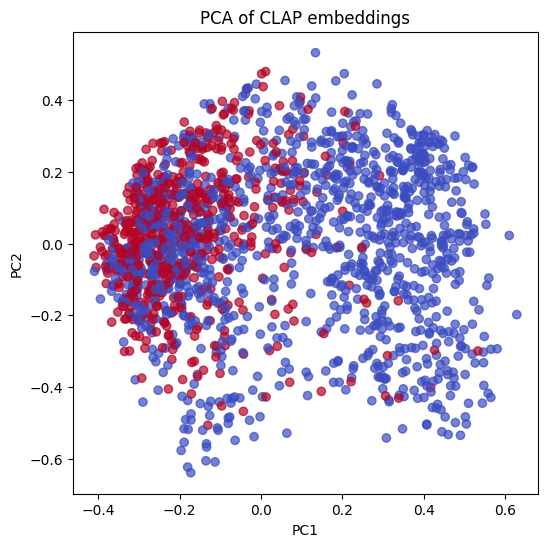

In [140]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = []
y = []

for xb, yb in train_loader:
    X.append(xb)
    y.append(yb)

X = torch.cat(X).numpy()
y = torch.cat(y).numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.title("PCA of CLAP embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


### Trying a different embedding model: TRILL

In [122]:
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

# Load TRILL
trill = hub.load("https://tfhub.dev/google/nonsemantic-speech-benchmark/trillsson2/1")

# Load test file (adjust path to match one of your WAVs)
filepath = "temp_chunks/0_nonvocaloid.wav"
y, sr = librosa.load(filepath, sr=16000, mono=True)
audio = tf.convert_to_tensor(y, dtype=tf.float32)[tf.newaxis, :]

# Run through TRILL
output = trill(audio)

# Examine keys and shapes
print("TRILL output keys:", output.keys())
print("Embedding shape:", output["embedding"].shape)


TRILL output keys: dict_keys(['embedding'])
Embedding shape: (1, 1024)


In [127]:
import os
import librosa
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tqdm import tqdm

# Patch for np.complex
np.complex = complex

# Settings
input_folder = "temp_chunks"
output_folder = "trill_embeddings"
csv_filename = "trill_embeddings.csv"
os.makedirs(output_folder, exist_ok=True)

# Load TRILL model
trill = hub.load("https://tfhub.dev/google/nonsemantic-speech-benchmark/trillsson2/1")

data = []

for filename in tqdm(os.listdir(input_folder), desc="Processing audio files"):
    if not filename.endswith(".wav"):
        continue

    filepath = os.path.join(input_folder, filename)
    label = filename.split("_")[-1].replace(".wav", "")  # 'vocaloid' or 'nonvocaloid'

    try:
        # Load and resample to 16kHz mono
        y, sr = librosa.load(filepath, sr=16000, mono=True)
        audio = tf.convert_to_tensor(y, dtype=tf.float32)[tf.newaxis, :]  # shape (1, samples)

        # Run through TRILL
        output = trill(audio)
        embedding_np = output['embedding'].numpy().squeeze()

        # if embedding_np.shape != (2048,):
        #     raise ValueError(f"Invalid embedding shape: {embedding_np.shape}")

        # Save .npy
        embed_filename = filename.replace(".wav", ".npy")
        embed_path = os.path.join(output_folder, embed_filename)
        np.save(embed_path, embedding_np)

        data.append({"filename": filename, "label": label, "embedding_path": embed_path})
    
    except Exception as e:
        print(f"⚠️ Error processing {filename}: {e}")

# Save CSV
df = pd.DataFrame(data)
df.to_csv(csv_filename, index=False)



Processing audio files: 100%|██████████| 2512/2512 [09:52<00:00,  4.24it/s]


In [128]:
print("Final embedding shape:", embedding_np.shape)


Final embedding shape: (1024,)


In [129]:
import torch
import numpy as np

embedding = np.load("trill_embeddings/0_nonvocaloid.npy")
print(embedding.shape)

(1024,)


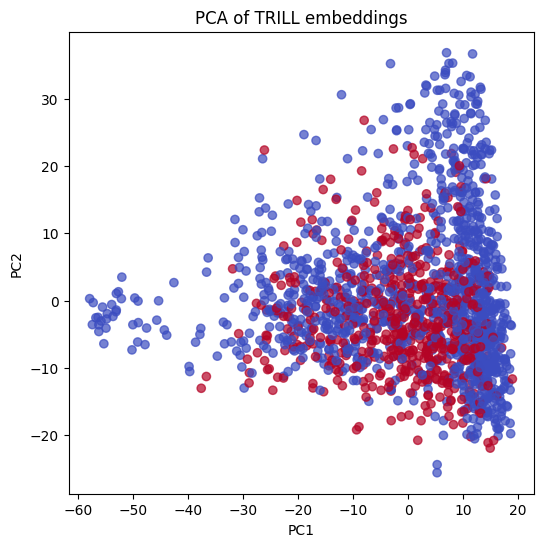

In [137]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = []
y = []

for xb, yb in train_loader:
    X.append(xb)
    y.append(yb)
    # if len(X) > :  # just get ~160 samples
    #     break

X = torch.cat(X).numpy()
y = torch.cat(y).numpy()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(6, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm", alpha=0.7)
plt.title("PCA of TRILL embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

>>> Next thing to do: try either an alternative embedding model OR resort to purely numerical analysis with extracted features OR modify the embeddings to make them meaningful directly like augmenting them with numerical extracted features

### Trying a different approach... Feature extraction with Librosa

In [7]:
import librosa
import numpy as np
import pandas as pd

def extract_features(audio_path: str, sr=22050, n_mfcc=13):
    y, sr = librosa.load(audio_path, sr=sr)
    
    y_harmonic, _ = librosa.effects.hpss(y)
    duration = librosa.get_duration(y=y, sr=sr)

    centroid = librosa.feature.spectral_centroid(y=y_harmonic, sr=sr)[0]
    flatness = librosa.feature.spectral_flatness(y=y_harmonic)[0]
    rolloff = librosa.feature.spectral_rolloff(y=y_harmonic, sr=sr)[0]
    contrast = librosa.feature.spectral_contrast(y=y_harmonic, sr=sr)
    flux = librosa.onset.onset_strength(y=y_harmonic, sr=sr)  # not true spectral flux, but usable

    mfcc = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)

    zcr = librosa.feature.zero_crossing_rate(y)[0]

    # Summary stats
    features = {
        "duration": duration,
        "zcr_mean": np.mean(zcr),
        "zcr_std": np.std(zcr),
        "centroid_mean": np.mean(centroid),
        "centroid_std": np.std(centroid),
        "flatness_mean": np.mean(flatness),
        "flatness_std": np.std(flatness),
        "rolloff_mean": np.mean(rolloff),
        "rolloff_std": np.std(rolloff),
        "onset_strength_mean": np.mean(flux),
        "onset_strength_std": np.std(flux),
    }

    for i in range(contrast.shape[0]):
        features[f"contrast_{i}_mean"] = np.mean(contrast[i])
        features[f"contrast_{i}_std"] = np.std(contrast[i])

    for i in range(n_mfcc):
        features[f"mfcc_{i+1}_mean"] = np.mean(mfcc[i])
        features[f"mfcc_{i+1}_std"] = np.std(mfcc[i])
        features[f"mfcc_delta_{i+1}_mean"] = np.mean(mfcc_delta[i])
        features[f"mfcc_delta2_{i+1}_mean"] = np.mean(mfcc_delta2[i])

    return features


In [10]:
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
from tqdm import tqdm

metadata = pd.read_csv("data/clips/metadata.csv")

def extract_wrapper(row):
    filepath, label = row["filepath"], row["label"]
    try:
        feats = extract_features(filepath)
        feats["filepath"] = filepath
        feats["label"] = label
        return feats
    except Exception as e:
        return {"filepath": filepath, "label": label, "error": str(e)}

MAX_WORKERS = 8

all_features = []
with ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    futures = {executor.submit(extract_wrapper, row): row for _, row in metadata.iterrows()}
    
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if "error" in result:
            print(f"Error processing {result['filepath']}: {result['error']}")
        else:
            all_features.append(result)

df = pd.DataFrame(all_features)
df.to_csv("vocaloid_features.csv", index=False)


  1%|          | 25/2713 [00:37<41:59,  1.07it/s]  /tmp/ipykernel_16870/2687251659.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
  2%|▏         | 53/2713 [01:26<1:19:11,  1.79s/it]/tmp/ipykernel_16870/2687251659.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Illegal Audio-MPEG-Header 0xfffb

Error processing data/clips/nonvocaloid/03 - Интерлюдия.mp3: float division by zero


 12%|█▏        | 327/2713 [08:51<31:59,  1.24it/s]  /tmp/ipykernel_16870/2687251659.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Note: Illegal Audio-MPEG-Header 0xfffb0000 at offset 192829.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).
 12%|█▏        | 331/2713 [09:01<1:02:48,  1.58s/it]/tmp/ipykernel_16870/2687251659.py:6: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path, sr=sr)
/root/miniconda3/envs/voca-audio/lib/python3.10/site

### Feature exploration and analysis with PCA and TSNE

In [85]:
df = pd.read_csv("vocaloid_features_parallel.csv")

In [61]:
X = df.drop(columns=["filepath", "label"])
y = df["label"].map({"vocaloid": 1, "nonvocaloid": 0})

In [8]:
X.describe()

,duration,zcr_mean,zcr_std,centroid_mean,centroid_std,flatness_mean,flatness_std,rolloff_mean,rolloff_std,onset_strength_mean,...,mfcc_delta_11_mean,mfcc_delta2_11_mean,mfcc_12_mean,mfcc_12_std,mfcc_delta_12_mean,mfcc_delta2_12_mean,mfcc_13_mean,mfcc_13_std,mfcc_delta_13_mean,mfcc_delta2_13_mean
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2.712000e+03,2712.000000,2712.000000,2712.000000,2712.000000,...,2.712000e+03,2.712000e+03,2712.000000,2712.000000,2.712000e+03,2.712000e+03,2712.000000,2712.000000,2.712000e+03,2712.000000
mean,198.890697,0.112535,0.058477,2054.164872,592.614935,1.902530e-02,0.062954,4353.324544,1287.566176,1.021336,...,2.206299e-04,4.295097e-05,2.523030,9.048558,4.763374e-05,1.402161e-05,-2.071994,9.158507,1.453371e-04,0.000020
std,108.116960,0.037402,0.023925,634.615196,222.951726,2.564319e-02,0.057189,1510.704428,462.938270,0.180644,...,2.151951e-03,7.839494e-04,5.443039,2.656063,2.073785e-03,7.137545e-04,4.843167,2.676721,2.204894e-03,0.000739
min,6.946667,0.008877,0.005280,201.982801,50.028883,7.600351e-07,0.000004,273.548064,97.802668,0.258826,...,-1.365404e-02,-7.590625e-03,-43.568584,3.236041,-2.608015e-02,-7.331591e-03,-33.227070,3.138492,-1.781164e-02,-0.007843
25%,124.899048,0.086026,0.043568,1612.937340,464.056860,5.956139e-03,0.015558,3289.694838,1002.966110,0.935703,...,-1.968782e-09,-1.346840e-05,-0.265427,7.231245,-3.855789e-06,-2.195169e-05,-4.898072,7.319377,-1.797046e-09,-0.000012
50%,204.033356,0.112548,0.056289,2123.465157,574.799797,1.608984e-02,0.047235,4600.248913,1254.934236,1.002436,...,1.037853e-10,2.237748e-12,2.993404,8.516085,2.827550e-11,-2.166999e-11,-2.042477,8.630299,1.529841e-10,0.000000
75%,253.705238,0.137851,0.071703,2512.524124,704.247075,2.618042e-02,0.100838,5498.358768,1547.308674,1.093793,...,1.065723e-04,8.431208e-06,5.921131,10.303242,5.739994e-05,5.025967e-06,0.814506,10.357543,9.443285e-05,0.000010
max,1309.573333,0.260698,0.259029,3880.134327,2883.507418,7.149212e-01,0.449867,8144.698953,3959.620416,2.093837,...,4.469230e-02,1.465648e-02,22.530077,30.709097,3.024566e-02,9.131170e-03,21.542976,30.701883,4.505222e-02,0.012346


Visualising the distribution of all of the features

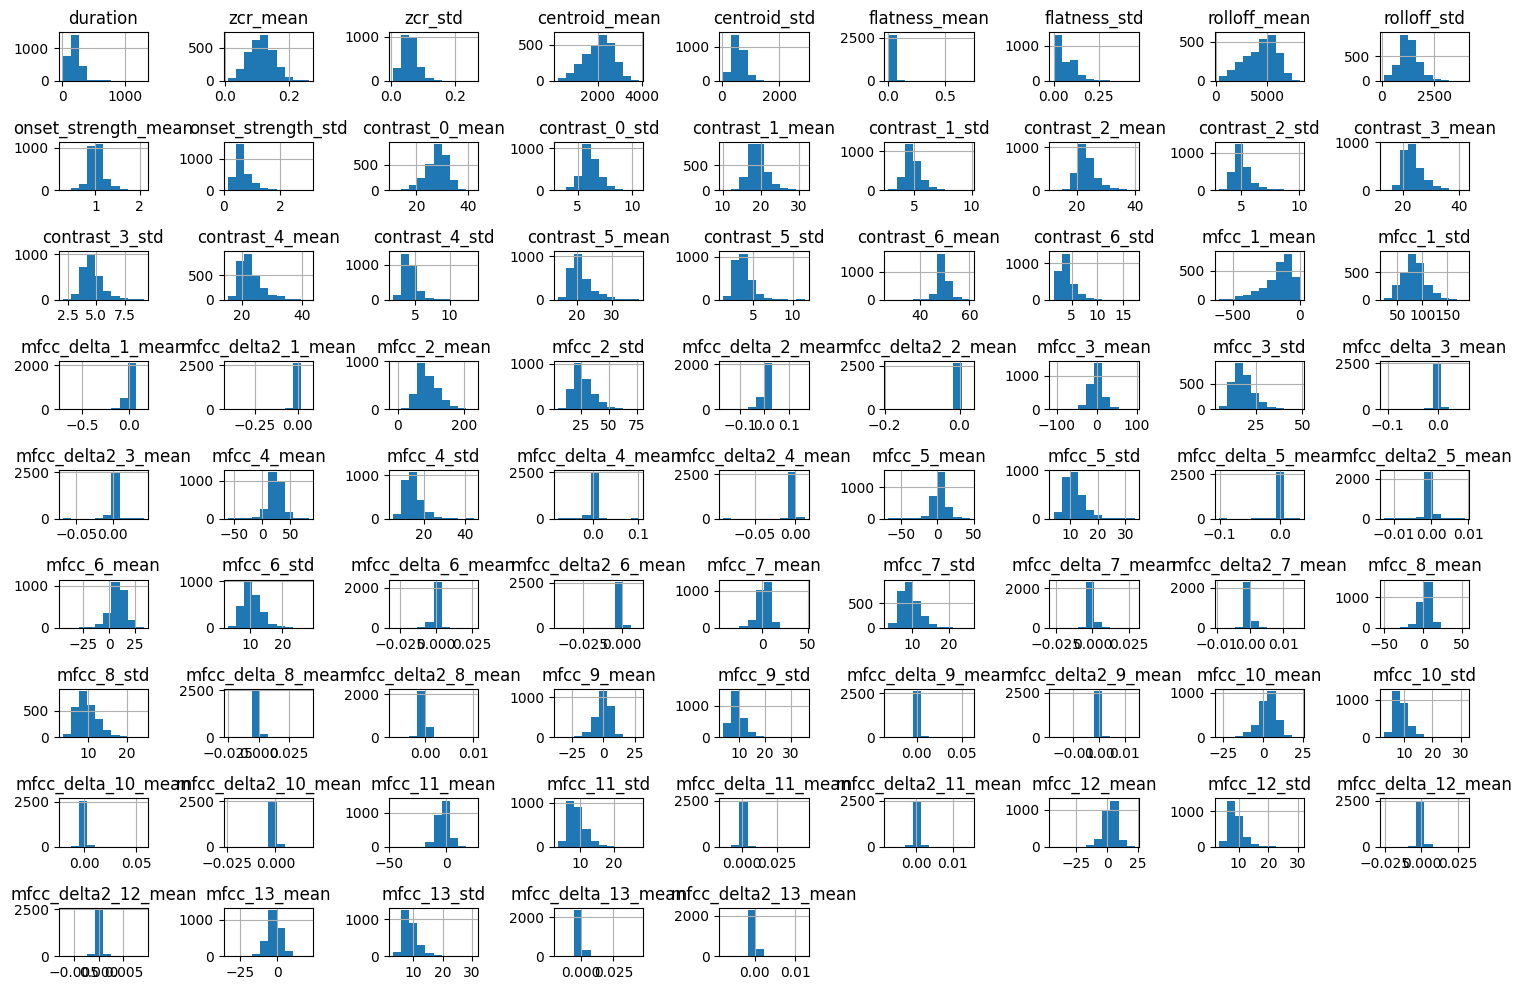

In [9]:

X.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

In [11]:
X.columns

Index(['duration', 'zcr_mean', 'zcr_std', 'centroid_mean', 'centroid_std',
       'flatness_mean', 'flatness_std', 'rolloff_mean', 'rolloff_std',
       'onset_strength_mean', 'onset_strength_std', 'contrast_0_mean',
       'contrast_0_std', 'contrast_1_mean', 'contrast_1_std',
       'contrast_2_mean', 'contrast_2_std', 'contrast_3_mean',
       'contrast_3_std', 'contrast_4_mean', 'contrast_4_std',
       'contrast_5_mean', 'contrast_5_std', 'contrast_6_mean',
       'contrast_6_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_delta_1_mean',
       'mfcc_delta2_1_mean', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_delta_2_mean',
       'mfcc_delta2_2_mean', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_delta_3_mean',
       'mfcc_delta2_3_mean', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_delta_4_mean',
       'mfcc_delta2_4_mean', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_delta_5_mean',
       'mfcc_delta2_5_mean', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_delta_6_mean',
       'mfcc_delta2_6_mean', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc

Removing delta features as they are very low variance

In [62]:
for i in X.columns:
    if 'delta' in i:
        print(f"Low variance column: {i} (var={X[i].var():.4f})")
        X.drop(columns=[i], inplace=True)

Low variance column: mfcc_delta_1_mean (var=0.0018)
Low variance column: mfcc_delta2_1_mean (var=0.0002)
Low variance column: mfcc_delta_2_mean (var=0.0002)
Low variance column: mfcc_delta2_2_mean (var=0.0000)
Low variance column: mfcc_delta_3_mean (var=0.0000)
Low variance column: mfcc_delta2_3_mean (var=0.0000)
Low variance column: mfcc_delta_4_mean (var=0.0000)
Low variance column: mfcc_delta2_4_mean (var=0.0000)
Low variance column: mfcc_delta_5_mean (var=0.0000)
Low variance column: mfcc_delta2_5_mean (var=0.0000)
Low variance column: mfcc_delta_6_mean (var=0.0000)
Low variance column: mfcc_delta2_6_mean (var=0.0000)
Low variance column: mfcc_delta_7_mean (var=0.0000)
Low variance column: mfcc_delta2_7_mean (var=0.0000)
Low variance column: mfcc_delta_8_mean (var=0.0000)
Low variance column: mfcc_delta2_8_mean (var=0.0000)
Low variance column: mfcc_delta_9_mean (var=0.0000)
Low variance column: mfcc_delta2_9_mean (var=0.0000)
Low variance column: mfcc_delta_10_mean (var=0.0000)
Lo

In [63]:
X.describe()

,duration,zcr_mean,zcr_std,centroid_mean,centroid_std,flatness_mean,flatness_std,rolloff_mean,rolloff_std,onset_strength_mean,...,mfcc_9_mean,mfcc_9_std,mfcc_10_mean,mfcc_10_std,mfcc_11_mean,mfcc_11_std,mfcc_12_mean,mfcc_12_std,mfcc_13_mean,mfcc_13_std
count,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2.712000e+03,2712.000000,2712.000000,2712.000000,2712.000000,...,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000
mean,198.890697,0.112535,0.058477,2054.164872,592.614935,1.902530e-02,0.062954,4353.324544,1287.566176,1.021336,...,-0.447293,9.169162,2.758445,9.095168,-2.617983,9.097842,2.523030,9.048558,-2.071994,9.158507
std,108.116960,0.037402,0.023925,634.615196,222.951726,2.564319e-02,0.057189,1510.704428,462.938270,0.180644,...,6.274413,2.652894,5.791422,2.624422,5.305674,2.639586,5.443039,2.656063,4.843167,2.676721
min,6.946667,0.008877,0.005280,201.982801,50.028883,7.600351e-07,0.000004,273.548064,97.802668,0.258826,...,-35.839565,3.714160,-28.031094,2.976210,-46.685753,3.443437,-43.568584,3.236041,-33.227070,3.138492
25%,124.899048,0.086026,0.043568,1612.937340,464.056860,5.956139e-03,0.015558,3289.694838,1002.966110,0.935703,...,-3.850507,7.402962,-0.304669,7.210870,-5.750357,7.284858,-0.265427,7.231245,-4.898072,7.319377
50%,204.033356,0.112548,0.056289,2123.465157,574.799797,1.608984e-02,0.047235,4600.248913,1254.934236,1.002436,...,0.340164,8.716058,3.288782,8.650438,-2.412498,8.630450,2.993404,8.516085,-2.042477,8.630299
75%,253.705238,0.137851,0.071703,2512.524124,704.247075,2.618042e-02,0.100838,5498.358768,1547.308674,1.093793,...,3.666640,10.430903,6.558014,10.507933,0.628878,10.414113,5.921131,10.303242,0.814506,10.357543
max,1309.573333,0.260698,0.259029,3880.134327,2883.507418,7.149212e-01,0.449867,8144.698953,3959.620416,2.093837,...,28.409132,35.247772,23.350822,31.481203,24.762941,27.664919,22.530077,30.709097,21.542976,30.701883


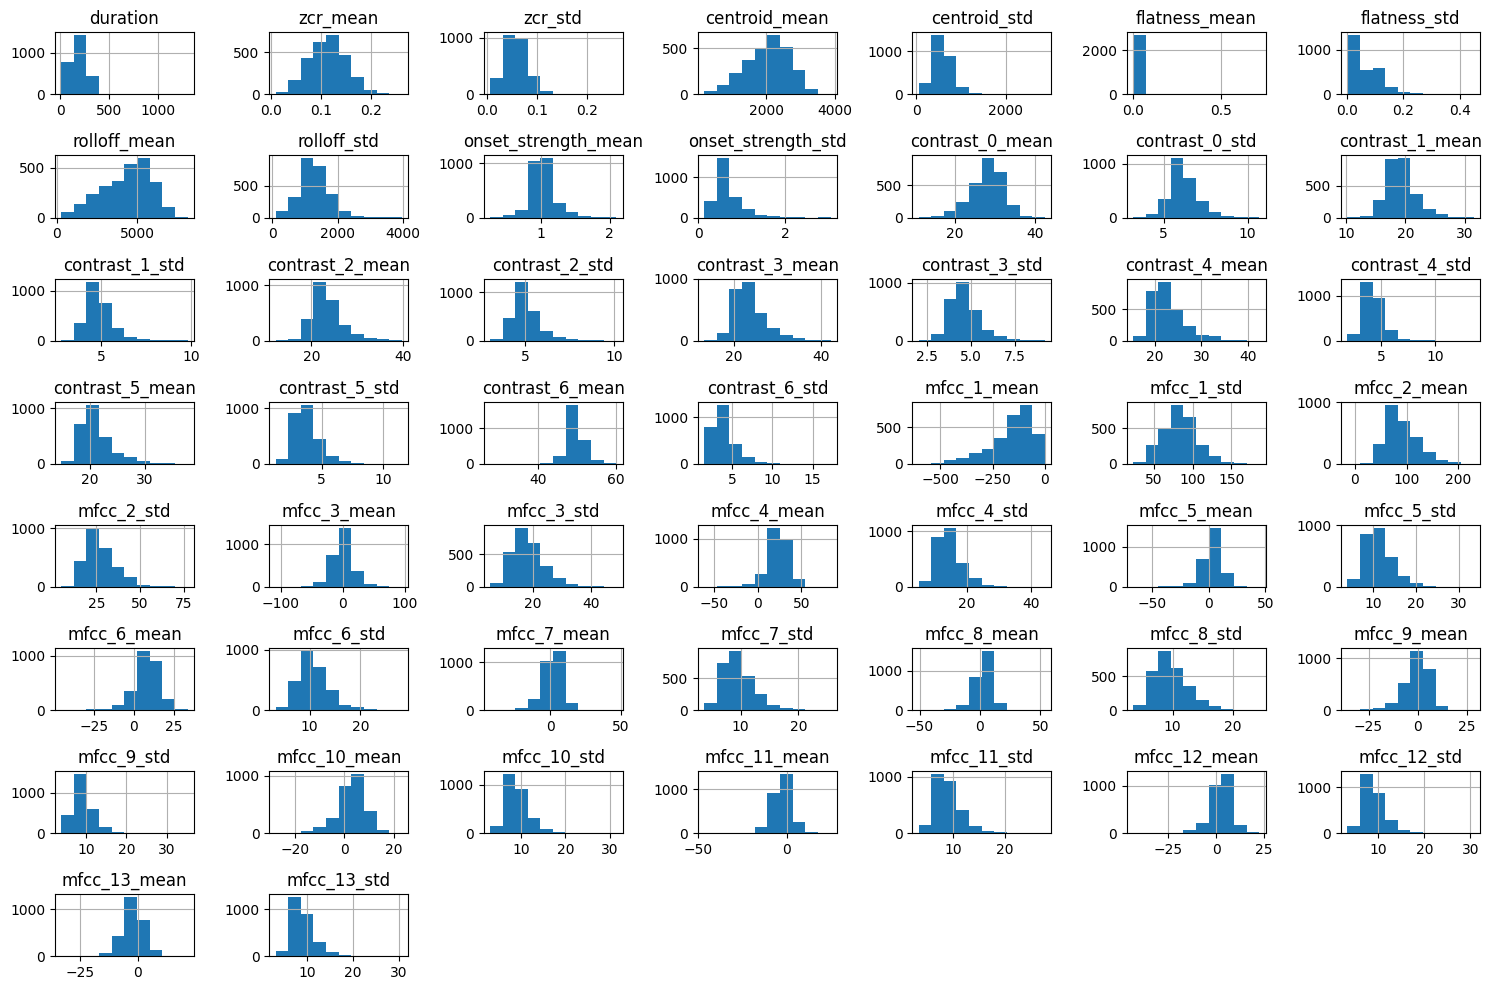

In [14]:

X.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

PCA to compress variables into just a few components - we encode >99.5% information in these

In [64]:
pca = PCA(n_components=3)
X = df.drop(columns=["label", "filepath"])
X_pca = pca.fit_transform(X)
y = df[["label"]]
y["label"] = y["label"].map({"vocaloid": 1, "nonvocaloid": 0})

/tmp/ipykernel_11185/1029925908.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["label"] = y["label"].map({"vocaloid": 1, "nonvocaloid": 0})


In [19]:
print(pca.explained_variance_ratio_)  # Shows % variance explained by each PC

[0.90773324 0.07938178 0.00560325 0.00367919]


In [20]:
print(np.sum(pca.explained_variance_ratio_))

0.9963974539015178


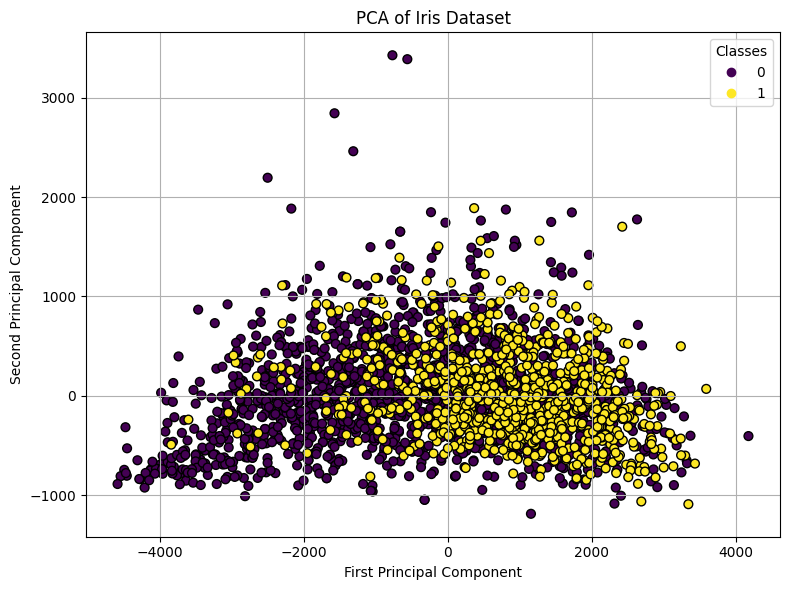

In [22]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values, cmap='viridis', edgecolor='k', s=40)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA of Iris Dataset')
plt.legend(*scatter.legend_elements(), title="Classes")
plt.grid(True)
plt.tight_layout()
plt.show()

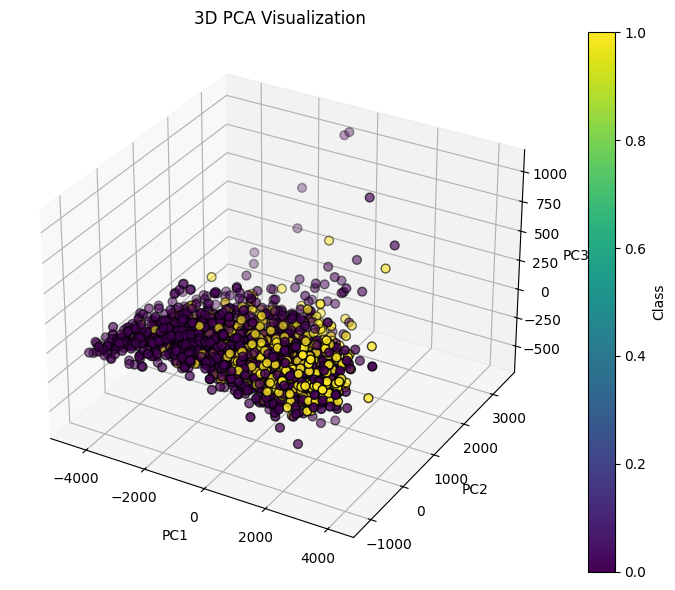

In [23]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
    c=y, cmap='viridis', s=40, edgecolor='k'
)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D PCA Visualization')
fig.colorbar(scatter, ax=ax, label='Class')
plt.tight_layout()
plt.show()


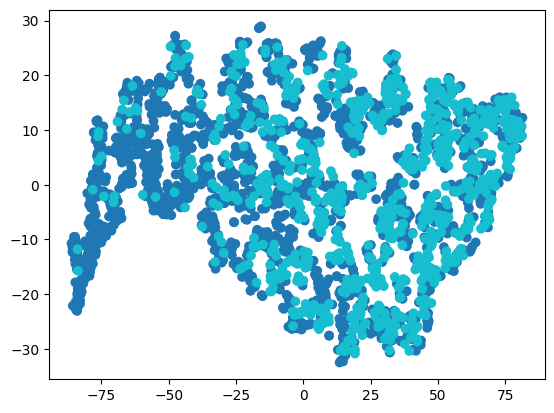

In [24]:
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y.values, cmap='tab10')


### Getting rid of correlated columns

<Axes: >

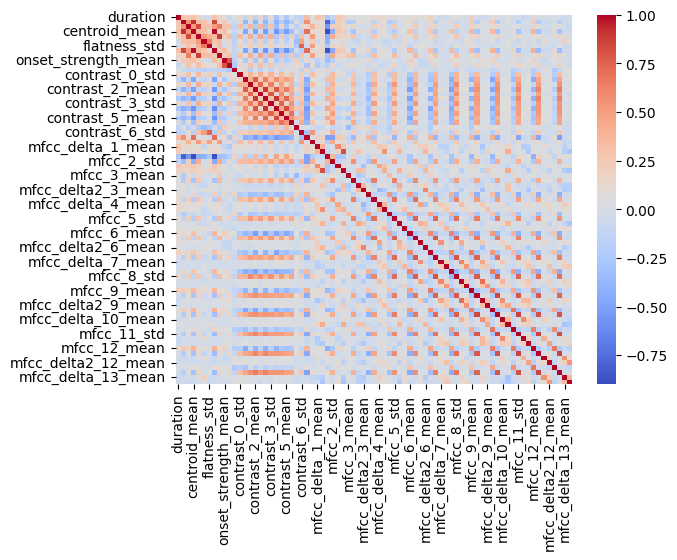

In [65]:
sns.heatmap(pd.DataFrame(X).corr(), cmap='coolwarm')


<Axes: >

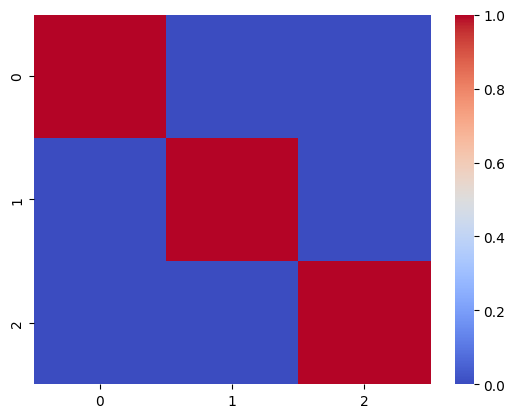

In [31]:
sns.heatmap(pd.DataFrame(X_pca).corr(), cmap='coolwarm')

In [66]:
# X_pca = pd.DataFrame(X_pca)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]
df_reduced = X.drop(columns=to_drop)


In [67]:
print(len(df_reduced.columns))

68


In [37]:
X_pca.to_csv("vocaloid_pca_reduced.csv", index=False)

In [68]:
df_reduced.to_csv("vocaloid_features_reduced.csv", index=False)

### ! Model selection and preliminary eval ! CONTINUE FROM HERE

In [69]:
df = pd.read_csv("vocaloid_features_reduced.csv")
# df = pd.read_csv("vocaloid_pca_reduced.csv")

In [70]:
df.describe()

,duration,zcr_mean,zcr_std,centroid_std,flatness_mean,flatness_std,onset_strength_mean,onset_strength_std,contrast_0_mean,contrast_0_std,...,mfcc_delta2_10_mean,mfcc_11_mean,mfcc_delta_11_mean,mfcc_delta2_11_mean,mfcc_12_mean,mfcc_delta_12_mean,mfcc_delta2_12_mean,mfcc_13_mean,mfcc_delta_13_mean,mfcc_delta2_13_mean
count,2712.000000,2712.000000,2712.000000,2712.000000,2.712000e+03,2712.000000,2712.000000,2712.000000,2712.000000,2712.000000,...,2.712000e+03,2712.000000,2.712000e+03,2.712000e+03,2712.000000,2.712000e+03,2.712000e+03,2712.000000,2.712000e+03,2712.000000
mean,198.890697,0.112535,0.058477,592.614935,1.902530e-02,0.062954,1.021336,0.669926,28.005498,6.166486,...,-4.132236e-05,-2.617983,2.206299e-04,4.295097e-05,2.523030,4.763374e-05,1.402161e-05,-2.071994,1.453371e-04,0.000020
std,108.116960,0.037402,0.023925,222.951726,2.564319e-02,0.057189,0.180644,0.303775,3.932873,0.856144,...,8.568785e-04,5.305674,2.151951e-03,7.839494e-04,5.443039,2.073785e-03,7.137545e-04,4.843167,2.204894e-03,0.000739
min,6.946667,0.008877,0.005280,50.028883,7.600351e-07,0.000004,0.258826,0.136343,10.948360,3.178864,...,-2.440156e-02,-46.685753,-1.365404e-02,-7.590625e-03,-43.568584,-2.608015e-02,-7.331591e-03,-33.227070,-1.781164e-02,-0.007843
25%,124.899048,0.086026,0.043568,464.056860,5.956139e-03,0.015558,0.935703,0.478769,25.701519,5.636983,...,-4.303526e-05,-5.750357,-1.968782e-09,-1.346840e-05,-0.265427,-3.855789e-06,-2.195169e-05,-4.898072,-1.797046e-09,-0.000012
50%,204.033356,0.112548,0.056289,574.799797,1.608984e-02,0.047235,1.002436,0.585211,28.430073,6.084907,...,-6.808569e-11,-2.412498,1.037853e-10,2.237748e-12,2.993404,2.827550e-11,-2.166999e-11,-2.042477,1.529841e-10,0.000000
75%,253.705238,0.137851,0.071703,704.247075,2.618042e-02,0.100838,1.093793,0.778931,30.621179,6.600005,...,1.353165e-09,0.628878,1.065723e-04,8.431208e-06,5.921131,5.739994e-05,5.025967e-06,0.814506,9.443285e-05,0.000010
max,1309.573333,0.260698,0.259029,2883.507418,7.149212e-01,0.449867,2.093837,3.035650,42.410402,10.693371,...,1.729140e-02,24.762941,4.469230e-02,1.465648e-02,22.530077,3.024566e-02,9.131170e-03,21.542976,4.505222e-02,0.012346


In [ ]:
scaler = StandardScaler()

In [87]:
df.columns

Index(['duration', 'zcr_mean', 'zcr_std', 'centroid_mean', 'centroid_std',
       'flatness_mean', 'flatness_std', 'rolloff_mean', 'rolloff_std',
       'onset_strength_mean', 'onset_strength_std', 'contrast_0_mean',
       'contrast_0_std', 'contrast_1_mean', 'contrast_1_std',
       'contrast_2_mean', 'contrast_2_std', 'contrast_3_mean',
       'contrast_3_std', 'contrast_4_mean', 'contrast_4_std',
       'contrast_5_mean', 'contrast_5_std', 'contrast_6_mean',
       'contrast_6_std', 'mfcc_1_mean', 'mfcc_1_std', 'mfcc_delta_1_mean',
       'mfcc_delta2_1_mean', 'mfcc_2_mean', 'mfcc_2_std', 'mfcc_delta_2_mean',
       'mfcc_delta2_2_mean', 'mfcc_3_mean', 'mfcc_3_std', 'mfcc_delta_3_mean',
       'mfcc_delta2_3_mean', 'mfcc_4_mean', 'mfcc_4_std', 'mfcc_delta_4_mean',
       'mfcc_delta2_4_mean', 'mfcc_5_mean', 'mfcc_5_std', 'mfcc_delta_5_mean',
       'mfcc_delta2_5_mean', 'mfcc_6_mean', 'mfcc_6_std', 'mfcc_delta_6_mean',
       'mfcc_delta2_6_mean', 'mfcc_7_mean', 'mfcc_7_std', 'mfcc

In [88]:
filenames = df['filepath']                  # Keep this separate!

# Now split everything together
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    X, y, filenames,
    test_size=0.3, 
    random_state=42
)

In [ ]:
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [ ]:
import joblib
joblib.dump(scaler, "vocaloid_scaler.pkl")

['vocaloid_scaler.pkl']

In [ ]:
def grid(model, model_name, params):
    print(f"Grid searching {model_name}...")
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, n_jobs=-1, verbose=0)
    grid_search.fit(X_scaled_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    return grid_search.best_estimator_

In [90]:
def model_test(best_model, model_name):
    print(f"Testing StandardScaler + {model_name}...")
    y_pred = best_model.predict(X_scaled_test)
    print(classification_report(y_test, y_pred, target_names=["nonvocaloid", "vocaloid"]))
    cm = confusion_matrix(y_test, y_pred)

    labels = ['Non-Vocaloid', 'Vocaloid']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels, cbar=False)

    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for StandardScaler + {model_name}')
    plt.tight_layout()
    plt.show()
    
    return model, y_pred

In [91]:
model = RandomForestClassifier()
model_xgboost = XGBClassifier()


In [92]:
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [93]:
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

Grid searching Random Forest...


/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/root/miniconda3/envs/voca-audio/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed whe

Best parameters for Random Forest: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Grid searching XGBoost...
Best parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'subsample': 0.8}
Testing StandardScaler + Random Forest...
              precision    recall  f1-score   support

 nonvocaloid       0.91      0.91      0.91       538
    vocaloid       0.82      0.82      0.82       276

    accuracy                           0.88       814
   macro avg       0.86      0.86      0.86       814
weighted avg       0.88      0.88      0.88       814



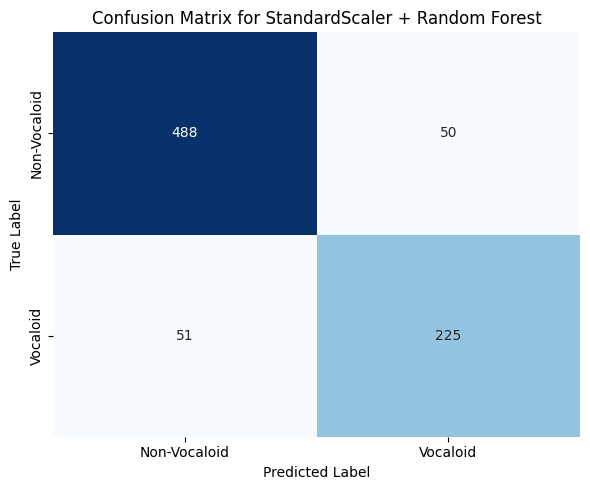

Testing StandardScaler + XGBoost...
              precision    recall  f1-score   support

 nonvocaloid       0.93      0.94      0.94       538
    vocaloid       0.88      0.86      0.87       276

    accuracy                           0.91       814
   macro avg       0.91      0.90      0.90       814
weighted avg       0.91      0.91      0.91       814



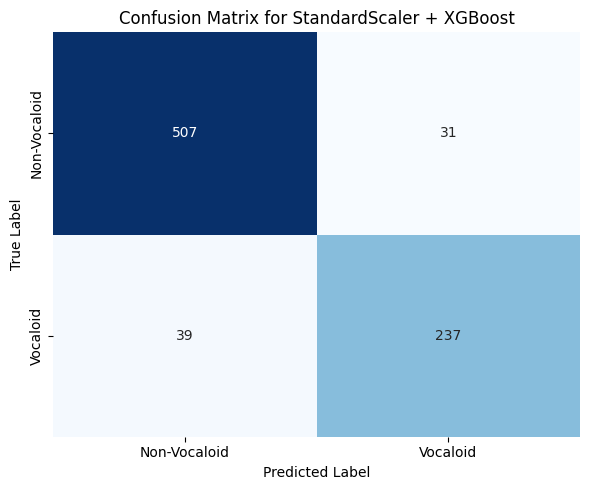

In [94]:
best_rf = grid(model, "Random Forest", rf_param_grid)
best_xgb = grid(model_xgboost, "XGBoost", xgb_param_grid)
_, y_pred_rf = model_test(best_rf, "Random Forest")
_, y_pred_xgb = model_test(best_xgb, "XGBoost")

In [95]:
import pickle

with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(best_rf, f)

with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(best_xgb, f)

Seeing what songs were misclassified

In [104]:
print(y_test['label'].values[:5])
print(y_pred_xgb[:5])

[0 0 1 1 1]
[0 0 1 1 1]


In [107]:
print(type(names_test))

<class 'pandas.core.series.Series'>


In [108]:
# Convert boolean mask to indices
misclassified_indices = np.where(y_test['label'].values != y_pred_xgb)[0]
misclassified_files = names_test.values[misclassified_indices]
print("Misclassified songs:", misclassified_files)

Misclassified songs: ['data/clips/vocaloid/05 すーばーばす.mp3'
 'data/clips/vocaloid/16. Lost Destination -鏡音レン & KAITO version-.mp3'
 'data/clips/vocaloid/03.無間地獄の子供達.mp3'
 'data/clips/nonvocaloid/01. Guilty Eyes Fever.mp3'
 'data/clips/nonvocaloid/02. Bound.mp3'
 'data/clips/nonvocaloid/01. G-senjou no Cinderella.mp3'
 'data/clips/vocaloid/18. Sunny Spring Day.mp3'
 'data/clips/vocaloid/06. Chakra.mp3'
 'data/clips/vocaloid/09. クリムゾンビート.mp3'
 'data/clips/vocaloid/15 サンドリヨン 10th Anniversary.mp3'
 'data/clips/nonvocaloid/02. Mou Hitori ja nai yo.mp3'
 'data/clips/vocaloid/01. 夢の底にもぐって.mp3' 'data/clips/vocaloid/16. ECHO.mp3'
 'data/clips/nonvocaloid/04. トリコリコPLEASE!!.flac'
 'data/clips/nonvocaloid/07 - The Wrong Side.mp3'
 'data/clips/nonvocaloid/11 Tide of Time.mp3'
 'data/clips/nonvocaloid/02. Love Novels.mp3'
 'data/clips/nonvocaloid/09. タテホコツバサ.flac'
 'data/clips/vocaloid/13 Kikuo - 混じる 2014.mp3'
 'data/clips/vocaloid/01. guriguri.mp3'
 'data/clips/nonvocaloid/01. Koi wa Taiyou ja nai？.m

TODO:

- maybe wrap Azure around this to show I can deploy? Perhaps a lil drift monitor never hurt anyone
- write blog perhaps :)
- maybe deploy on a streamlit website so a person can literally just put in a song and the model will tell you if it's vocaloid or not